# Telecom Churn Case Study

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

import re
import random
import datetime

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Print python, jupyter and all the imported library versions
import sys
import jupyter_core
import matplotlib as mpt
import statsmodels as stm
import sklearn as skln

print("python : {0}".format(sys.version))
print("jupyter : {0}".format(jupyter_core.__version__))
print("numpy : {0}".format(np.__version__))
print("pandas : {0}".format(pd.__version__))
print("matplotlib : {0}".format(mpt.__version__))
print("seaborn : {0}".format(sns.__version__))
print("xgboost : {0}".format(xgb.__version__))
print("sklearn : {0}".format(skln.__version__))
print("statsmodel : {0}".format(stm.__version__))

python : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]
jupyter : 5.7.2
numpy : 1.26.4
pandas : 2.2.2
matplotlib : 3.9.2
seaborn : 0.13.2
xgboost : 2.1.3
sklearn : 1.5.1
statsmodel : 0.14.2


# Data Understanding

In [3]:
# Load the training dataset, testing data and data dictionary
train_data = pd.read_csv("datasets/train.csv")
test_data = pd.read_csv("datasets/test.csv")
data_dict = pd.read_csv("others/data_dictionary.csv")

In [4]:
# Print the data dictionary
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [5]:
# Print the shape of training data
train_data.shape

(69999, 172)

In [6]:
# Print all columns in the training dataset
pd.set_option('display.max_info_columns', len(train_data.columns))
pd.set_option('display.max_columns', len(train_data.columns))
pd.set_option('display.max_rows', len(train_data.columns))

In [7]:
train_data.columns.tolist()

['id',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 

In [8]:
# Print the first 5 rows of training data
train_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [9]:
# Print information of the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [10]:
# Describe data within the training data
train_data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [11]:
# Drop columns where more than 50% of the rows are empty in training data
threshold = len(train_data) * 0.5
train_data = train_data.dropna(axis = 1, thresh = threshold)
train_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.00,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/

In [12]:
# Drop rows where more than 50% of the columns are empty in training data
threshold = len(train_data.columns) * 0.5
train_data = train_data.dropna(axis = 0, ignore_index = True, thresh = threshold)
train_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.00,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/

In [13]:
# Find all the columns where the number of values in the column is singular
# These will not contribute towards model building
single_value_cols = set([col for col in train_data.columns if len(train_data[col].value_counts()) == 1])
print("Columns with only one value =", single_value_cols)
train_data = train_data.drop(single_value_cols, axis = 1)
train_data

Columns with only one value = {'std_ic_t2o_mou_6', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_8', 'last_date_of_month_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_6', 'loc_og_t2o_mou', 'circle_id', 'last_date_of_month_7', 'last_date_of_month_8', 'loc_ic_t2o_mou', 'std_ic_t2o_mou_7', 'std_og_t2o_mou'}


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.0,0.0,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.00,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.60,0.56,0.0,0.0,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,24.98,4.84,23.88,53.99,44

In [14]:
# Remove columns for T2T, T2M etc for minutes of usage as the total value is part of other columns and will be more relevant
operator_mobile = [col for col in list(train_data.columns) if re.search('t2t_mou', col)]
operator_fixed = [col for col in list(train_data.columns) if re.search('t2f_mou', col)]
operator_call_center = [col for col in list(train_data.columns) if re.search('t2c_mou', col)]
operator_other_mobile = [col for col in list(train_data.columns) if re.search('t2m_mou', col)]
operator_other_fixed = [col for col in list(train_data.columns) if re.search('t2o_mou', col)]
roaming = [col for col in list(train_data.columns) if re.search('roam', col)]

removal_columns = [*operator_mobile, *operator_fixed, *operator_call_center, *operator_other_mobile, *operator_other_fixed, *roaming]
train_data = train_data.drop(removal_columns, axis = 1)
train_data

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [15]:
# Fill data as 0.0 for customers which have the ARPU (Avg revenue per user) as less than 0 for the same month
def fill_data_for_zero_revenue_customers(data):
    
    impute_columns = ['onnet_mou', 'offnet_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 
                  'loc_ic_mou', 'std_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others']
    suffixes = ['_6', '_7', '_8']
    
    for impute_column in impute_columns:
        for suffix in suffixes:
            
            column = impute_column + suffix
            filtered_data = data[data[column].isna()]
            
            filtered_data = filtered_data[filtered_data['arpu' + suffix] <= 0]
            data.loc[filtered_data.index, column] = 0

    return data
    
fill_data_for_zero_revenue_customers(train_data)

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [16]:
# Fill data as 0.0 for outgoing/incoming call types where customers have total outgoing/incoming calls as 0 in the training dataset
def fill_data_for_og_ic_calls(data):
    
    impute_columns = {
        'loc_og_mou': 'total_og_mou',
        'std_og_mou': 'total_og_mou',
        'isd_og_mou': 'total_og_mou',
        'spl_og_mou': 'total_og_mou',
        'og_others': 'total_og_mou',
        'loc_ic_mou': 'total_ic_mou',
        'std_ic_mou': 'total_ic_mou',
        'isd_ic_mou': 'total_ic_mou',
        'spl_ic_mou': 'total_ic_mou',
        'ic_others': 'total_ic_mou'
    }
    suffixes = ['_6', '_7', '_8']
    
    for impute_column in impute_columns:
        for suffix in suffixes:
            
            column = impute_column + suffix
            total = impute_columns[impute_column] + suffix
            filtered_data = data[data[column].isna()]
            
            total_filtered_data = filtered_data[filtered_data[total] == 0]
            data.loc[total_filtered_data.index, column] = 0

    return data
    
fill_data_for_og_ic_calls(train_data)

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [17]:
# Fill data as 0.0 for network call types where customers have total calls as 0 in the training dataset
def fill_data_for_net_calls(data):

    impute_columns = ['onnet_mou', 'offnet_mou']
    suffixes = ['_6', '_7', '_8']

    for impute_column in impute_columns:
        for suffix in suffixes:
    
            column = impute_column + suffix
            filtered_data = data[data[column].isna()]
            
            total_filtered_data = filtered_data[(filtered_data['total_og_mou' + suffix] + filtered_data['total_ic_mou' + suffix]) == 0]
            data.loc[total_filtered_data.index, column] = 0

    return data

fill_data_for_net_calls(train_data)

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [18]:
# Create a singular function to fill all the data (by invoking corresponding functions) and return the modified dataset
def fill_data(data):
    data = fill_data_for_zero_revenue_customers(data)
    data = fill_data_for_og_ic_calls(data)
    data = fill_data_for_net_calls(data)
    return data

train_data = fill_data(train_data)
train_data

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [19]:
# Drop id column from the data frame as it's not relevant for analysis
train_data = train_data.drop(["id"], axis = 1)
train_data

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,48.54,83.53,80.24,112.43,136.0

# Feature Engineering

In [20]:
# Convert datetime columns from string to datetime format for further processing
def convert_data_to_datetime(data):
    
    columns = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

    for column in columns:
        data[column] = data[column].replace(0, np.nan)
        data[column] = pd.to_datetime(data[column])

    return data

convert_data_to_datetime(train_data)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,2014-06-22,2014-07-10,2014-08-24,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,2014-06-12,2014-07-10,2014-08-26,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,2014-06-11,2014-07-22,2014-08-24,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,2014-06-15,2014-07-21,2014-08-25,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,2014-06-25,2014-07-26,2014-08-30,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,2014-06-18,2014-07-31,2014-08-31,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,48.54,83.53,

In [21]:
# Find number of days since last recharge, for calculation assume period is starting on 1st June 2014 and 
# ending on 31st August 2014
start_date = datetime.datetime(2014, 5, 31)
end_date = datetime.datetime(2014, 8, 31)

def days_since_last_recharge(row):
    if row.date_of_last_rech_8 is not pd.NaT:
        return (end_date - row.date_of_last_rech_8).days
    elif row.date_of_last_rech_7 is not pd.NaT:
        return (end_date - row.date_of_last_rech_7).days
    elif row.date_of_last_rech_6 is not pd.NaT:
        return (end_date - row.date_of_last_rech_6).days
    else:
        return (end_date - start_date).days

def create_days_since_last_recharge(data):
    data['days_since_last_rech'] = data.apply(days_since_last_recharge, axis=1)
    return data

create_days_since_last_recharge(train_data)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_since_last_rech
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,2014-06-22,2014-07-10,2014-08-24,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0,7
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,2014-06-12,2014-07-10,2014-08-26,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0,5
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,2014-06-11,2014-07-22,2014-08-24,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0,7
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,2014-06-15,2014-07-21,2014-08-25,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0,6
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,2014-06-25,2014-07-26,2014-08-30,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,2014-06-18,2014-07-31,2014-08-31,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0,0
69237,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69

In [23]:
# Create columns for totals of various statistics list minutes of usage, average revenue etc
totals_column = lambda data, column: data[column + '_6'] + data[column + '_7'] + data[column + '_8']

# Create column for calculating average change in statistics between June and August
average_change_column = lambda data, column: (data[column + '_8'] - data[column + '_6']) / 2

# Drop columns for which data has been generated
drop_column = lambda data, column: data.drop([column + '_6', column + '_7', column + '_8'], axis = 1)

def create_totals_average_change_column(data) :
    for column in ['arpu', 'onnet_mou', 'offnet_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 
                   'loc_ic_mou', 'std_ic_mou', 'isd_ic_mou', 'spl_ic_mou', 'ic_others', 'total_ic_mou', 'vol_2g_mb', 'vol_3g_mb',
                  'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'total_rech_num', 'total_rech_amt']:
        data[column + '_total'] = totals_column(data, column)
        data[column + '_avg_change'] = average_change_column(data, column)
        data = drop_column(data, column)
    return data

create_totals_column(train_data)

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_since_last_rech,arpu_total,arpu_avg_change,onnet_mou_total,onnet_mou_avg_change,offnet_mou_total,offnet_mou_avg_change,loc_og_mou_total,loc_og_mou_avg_change,std_og_mou_total,std_og_mou_avg_change,isd_og_mou_total,isd_og_mou_avg_change,spl_og_mou_total,spl_og_mou_avg_change,og_others_total,og_others_avg_change,total_og_mou_total,total_og_mou_avg_change,loc_ic_mou_total,loc_ic_mou_avg_change,std_ic_mou_total,std_ic_mou_avg_change,isd_ic_mou_total,isd_ic_mou_avg_change,spl_ic_mou_total,spl_ic_mou_avg_change,ic_others_total,ic_others_avg_change,total_ic_mou_total,total_ic_mou_avg_change,vol_2g_mb_total,vol_2g_mb_avg_change,vol_3g_mb_total,vol_3g_mb_avg_change,monthly_2g_total,monthly_2g_avg_change,sachet_2g_total,sachet_2g_avg_change,monthly_3g_total,monthly_3g_avg_change,sachet_3g_total,sachet_3g_avg_change,total_rech_num_total,total_rech_num_avg_change,total_rech_amt_total,total_rech_amt_avg_change
0,65,65,10,2014-06-22,2014-07-10,2014-08-24,65,65,0,1958,0.00,0.00,0.00,0,7,125.813,-11.8750,174.25,-23.645,131.25,-14.955,26.18,-2.460,271.09,-32.040,0.00,0.000,8.83,-4.100,0.38,-0.19,306.52,-38.790,52.73,10.725,50.22,3.860,0.00,0.000,0.66,0.330,1.80,-0.555,105.44,14.360,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,7,-0.5,152,-33.5
1,0,145,50,2014-06-12,2014-07-10,2014-08-26,0,0,0,710,0.00,0.00,0.00,0,5,165.740,21.4765,0.00,0.000,56.88,15.445,0.00,0.000,0.00,0.000,0.00,0.000,62.39,15.830,0.00,0.00,62.39,15.830,67.91,10.795,0.00,0.000,0.00,0.000,0.01,0.005,0.00,0.000,67.92,10.800,352.91,0.000,3.96,0.00,0,0.0,0,0.0,1,0.0,0,0.0,12,1.0,195,25.0
2,70,70,0,2014-06-11,2014-07-22,2014-08-24,70,50,0,882,0.00,0.00,0.00,0,7,163.982,-30.4030,16.46,-0.265,136.04,-26.995,37.62,-12.320,113.93,-14.470,0.00,0.000,4.27,-1.445,0.00,0.00,155.85,-28.245,155.73,-32.185,38.77,-11.765,0.00,0.000,0.00,0.000,0.25,0.125,194.76,-43.825,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,8,0.0,190,-35.0
3,110,110,50,2014-06-15,2014-07-21,2014-08-25,110,110,50,982,0.00,0.00,0.00,0,6,472.717,-22.6335,23.27,-3.630,197.47,-9.265,117.38,-10.640,58.75,-5.780,0.00,0.000,49.69,5.330,0.00,0.00,225.85,-11.095,217.13,-2.590,11.98,-3.040,0.00,0.000,0.00,0.000,0.00,0.000,229.13,-5.635,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,9,0.5,530,-15.0
4,50,41,30,2014-06-25,2014-07-26,2014-08-30,25,10,30,647,0.00,0.00,0.00,0,1,470.464,-69.5715,32.24,-7.575,104.73,-23.680,100.61,-21.575,4.35,-2.175,0.00,0.000,17.00,0.000,0.00,0.00,121.96,-23.750,59.21,3.385,0.00,0.000,0.00,0.000,0.00,0.000,0.00,0.000,59.21,3.385,913.16,-88.665,0.00,0.00,0,0.0,19,-0.5,0,0.0,1,0.0,31,-2.5,548,-84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,50,110,130,2014-06-18,2014-07-31,2014-08-31,50,20,130,221,0.00,0.00,0.00,0,0,755.820,156.6880,18.29,5.465,870.10,190.820,159.95,48.430,713.41,146.940,0.00,0.000,15.88,0.915,0.00,0.00,889.26,196.290,457.75,128.880,33.78,5.895,0.00,0.000,0.00,0.000,0.00,0.000,491.55,134.780,388.90,72.155,0.00,0.00,0,0.0,7,0.5,0,0.0,1,0.0,31,6.0,959,231.0
69237,90,44,44,2014-06-28,2014-07-31,2014-08-27,50,30,42,712,0.00,0.00,0.00,0,4,714.984,52.8445,545.63,58.045,193.87,-0.735,207.10,4.840,528.19,52.375,0.00,0.000,4.32,0.025,0.00,0.00,739.64,57.240,170.41,-1.375,157.66,28.970,0.00,0.000,0.50,0.250,0.08,0.040,328.68,27.885,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,25,2.0,821,54.0
69238,279,250,349,2014-06-25,2014-07-30,2014-08-29,279,250,48,879,0.00,0.00,0.00,0,2,910.244,-46.1530,224.01,0.655,827.32,-35.850,973.33,-10.310,24.16,0.000,0.21,-0.105,53.64,-24.770,0.00,0.00,1051.36,-35.195,1354.97,-58.735,4.98,-0.010,5.10,-2.500,0.00,0.000,8.23,-2.570,1373.30,-63.820,0

In [24]:
# Creare a singular function to modify existing columns or create new columns and return the modified dataset
def create_and_modify_columns(data):
    data = convert_data_to_datetime(data)
    data = create_days_since_last_recharge(data)
    data = create_totals_average_change_column(data)
    return data

train_data = create_and_modify_columns(train_data)
train_data

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_since_last_rech,arpu_total,arpu_avg_change,onnet_mou_total,onnet_mou_avg_change,offnet_mou_total,offnet_mou_avg_change,loc_og_mou_total,loc_og_mou_avg_change,std_og_mou_total,std_og_mou_avg_change,isd_og_mou_total,isd_og_mou_avg_change,spl_og_mou_total,spl_og_mou_avg_change,og_others_total,og_others_avg_change,total_og_mou_total,total_og_mou_avg_change,loc_ic_mou_total,loc_ic_mou_avg_change,std_ic_mou_total,std_ic_mou_avg_change,isd_ic_mou_total,isd_ic_mou_avg_change,spl_ic_mou_total,spl_ic_mou_avg_change,ic_others_total,ic_others_avg_change,total_ic_mou_total,total_ic_mou_avg_change,vol_2g_mb_total,vol_2g_mb_avg_change,vol_3g_mb_total,vol_3g_mb_avg_change,monthly_2g_total,monthly_2g_avg_change,sachet_2g_total,sachet_2g_avg_change,monthly_3g_total,monthly_3g_avg_change,sachet_3g_total,sachet_3g_avg_change,total_rech_num_total,total_rech_num_avg_change,total_rech_amt_total,total_rech_amt_avg_change
0,65,65,10,2014-06-22,2014-07-10,2014-08-24,65,65,0,1958,0.00,0.00,0.00,0,7,125.813,-11.8750,174.25,-23.645,131.25,-14.955,26.18,-2.460,271.09,-32.040,0.00,0.000,8.83,-4.100,0.38,-0.19,306.52,-38.790,52.73,10.725,50.22,3.860,0.00,0.000,0.66,0.330,1.80,-0.555,105.44,14.360,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,7,-0.5,152,-33.5
1,0,145,50,2014-06-12,2014-07-10,2014-08-26,0,0,0,710,0.00,0.00,0.00,0,5,165.740,21.4765,0.00,0.000,56.88,15.445,0.00,0.000,0.00,0.000,0.00,0.000,62.39,15.830,0.00,0.00,62.39,15.830,67.91,10.795,0.00,0.000,0.00,0.000,0.01,0.005,0.00,0.000,67.92,10.800,352.91,0.000,3.96,0.00,0,0.0,0,0.0,1,0.0,0,0.0,12,1.0,195,25.0
2,70,70,0,2014-06-11,2014-07-22,2014-08-24,70,50,0,882,0.00,0.00,0.00,0,7,163.982,-30.4030,16.46,-0.265,136.04,-26.995,37.62,-12.320,113.93,-14.470,0.00,0.000,4.27,-1.445,0.00,0.00,155.85,-28.245,155.73,-32.185,38.77,-11.765,0.00,0.000,0.00,0.000,0.25,0.125,194.76,-43.825,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,8,0.0,190,-35.0
3,110,110,50,2014-06-15,2014-07-21,2014-08-25,110,110,50,982,0.00,0.00,0.00,0,6,472.717,-22.6335,23.27,-3.630,197.47,-9.265,117.38,-10.640,58.75,-5.780,0.00,0.000,49.69,5.330,0.00,0.00,225.85,-11.095,217.13,-2.590,11.98,-3.040,0.00,0.000,0.00,0.000,0.00,0.000,229.13,-5.635,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,9,0.5,530,-15.0
4,50,41,30,2014-06-25,2014-07-26,2014-08-30,25,10,30,647,0.00,0.00,0.00,0,1,470.464,-69.5715,32.24,-7.575,104.73,-23.680,100.61,-21.575,4.35,-2.175,0.00,0.000,17.00,0.000,0.00,0.00,121.96,-23.750,59.21,3.385,0.00,0.000,0.00,0.000,0.00,0.000,0.00,0.000,59.21,3.385,913.16,-88.665,0.00,0.00,0,0.0,19,-0.5,0,0.0,1,0.0,31,-2.5,548,-84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,50,110,130,2014-06-18,2014-07-31,2014-08-31,50,20,130,221,0.00,0.00,0.00,0,0,755.820,156.6880,18.29,5.465,870.10,190.820,159.95,48.430,713.41,146.940,0.00,0.000,15.88,0.915,0.00,0.00,889.26,196.290,457.75,128.880,33.78,5.895,0.00,0.000,0.00,0.000,0.00,0.000,491.55,134.780,388.90,72.155,0.00,0.00,0,0.0,7,0.5,0,0.0,1,0.0,31,6.0,959,231.0
69237,90,44,44,2014-06-28,2014-07-31,2014-08-27,50,30,42,712,0.00,0.00,0.00,0,4,714.984,52.8445,545.63,58.045,193.87,-0.735,207.10,4.840,528.19,52.375,0.00,0.000,4.32,0.025,0.00,0.00,739.64,57.240,170.41,-1.375,157.66,28.970,0.00,0.000,0.50,0.250,0.08,0.040,328.68,27.885,0.00,0.000,0.00,0.00,0,0.0,0,0.0,0,0.0,0,0.0,25,2.0,821,54.0
69238,279,250,349,2014-06-25,2014-07-30,2014-08-29,279,250,48,879,0.00,0.00,0.00,0,2,910.244,-46.1530,224.01,0.655,827.32,-35.850,973.33,-10.310,24.16,0.000,0.21,-0.105,53.64,-24.770,0.00,0.00,1051.36,-35.195,1354.97,-58.735,4.98,-0.010,5.10,-2.500,0.00,0.000,8.23,-2.570,1373.30,-63.820,0

# Data Visualisation (EDA)

In [28]:
# Define a list of colors and palettes, and define function to choose randomly
color_list = ["seagreen", "red", "orange", "blue", "pink", "green", "brown", "darkblue", "purple", "grey"]
palette_list = ["Set1", "Set2", "Set3", "Paired", "muted", "deep", "pastel", "hls", "husl"]
cmap_list = ["Spectral", "Greens", "flare_r"]

random_color = lambda: random.choice(color_list)
random_palette = lambda: random.choice(palette_list)
random_cmap = lambda: random.choice(cmap_list)

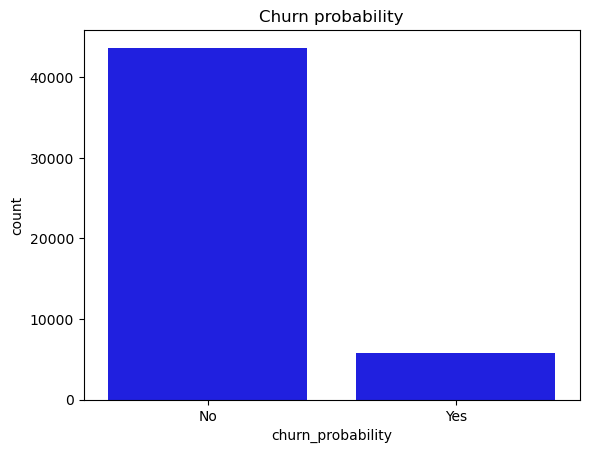

In [67]:
# Plot the key column (churn probability) as count plot
sns.countplot(x=train_data["churn_probability"], color=random_color())
plt.xticks([0, 1], ["No", "Yes"])
plt.title("Churn probability")
plt.show()

In [60]:
# Define a function to draw hist plots with the given features and choosing colors randomly
def draw_hist_plots(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        columns = features[i]["columns"]
        plot = sns.histplot(data = data.loc[:, columns.keys()], 
            color = random_color(), 
            bins = 10, 
            log_scale=features[i]["log"], 
            multiple="stack")
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

In [47]:
# Draw boxplots for features grouped together for months
# features = [
#     {
#         "columns": { "arpu_6": "June", "arpu_7": "July", "arpu_8": "August" },
#         "title": "Average Revenue per User",
#         "log": True
#     },
#     {
#         "columns": { "loc_og_mou_6": "June", "loc_og_mou_7": "July", "loc_og_mou_8": "August", },
#         "title": "Local Outgoing Monthly Usage",
#         "log": True
#     },
#     {
#         "columns": { "loc_ic_mou_6": "June", "loc_ic_mou_7": "July", "loc_ic_mou_8": "August", },
#         "title": "Local Incoming Monthly Usage",
#         "log": True
#     },
#     {
#         "columns": { "total_og_mou_6": "June", "total_og_mou_7": "July", "total_og_mou_8": "August", },
#         "title": "Total Outgoing Monthly Usage",
#         "log": True
#     },
#     {
#         "columns": { "total_ic_mou_6": "June", "total_ic_mou_7": "July", "total_ic_mou_8": "August", },
#         "title": "Total Incoming Monthly Usage",
#         "log": True
#     },
#     {
#         "columns": { "total_rech_amt_6": "June", "total_rech_amt_7": "July", "total_rech_amt_8": "August", },
#         "title": "Total Recharge Amount",
#         "log": True
#     },
#     {
#         "columns": { "vol_2g_mb_6": "June", "vol_2g_mb_7": "July", "vol_2g_mb_8": "August", },
#         "title": "Mobile Internet Usage (2G)",
#         "log": True
#     },
#     {
#         "columns": { "vol_3g_mb_6": "June", "vol_3g_mb_7": "July", "vol_3g_mb_8": "August", },
#         "title": "Mobile Internet Usage (3G)",
#         "log": True
#     }
# ]
# draw_hist_plots([3, 4], train_data, features)

In [44]:
# Define a function to draw hist plots with the given features and choosing colors randomly
def draw_dis_plots(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        # columns = features[i]["columns"]
        plot = sns.histplot(data = data, 
                            x = features[i]["x"],
                            hue = features[i]["hue"],
                            color = random_color(),
                            log_scale=True)
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

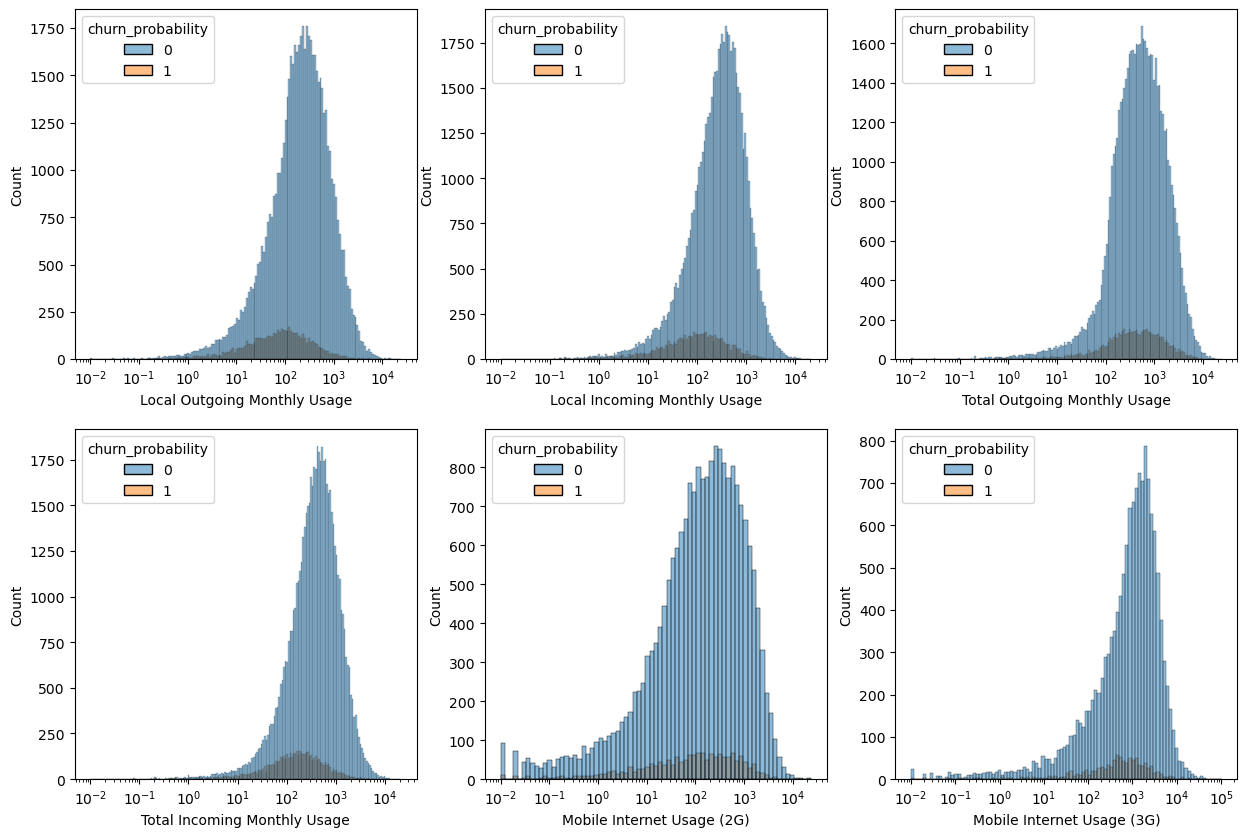

In [46]:
# Draw boxplots for features grouped together for months
features = [
    {
        "x": "loc_og_mou_total",
        "hue": "churn_probability",
        "title": "Local Outgoing Monthly Usage"
    },
    {
        "x": "loc_ic_mou_total",
        "hue": "churn_probability",
        "title": "Local Incoming Monthly Usage"
    },
    {
        "x": "total_og_mou_total",
        "hue": "churn_probability",
        "title": "Total Outgoing Monthly Usage"
    },
    {
        "x": "total_ic_mou_total",
        "hue": "churn_probability",
        "title": "Total Incoming Monthly Usage"
    },
    {
        "x": "vol_2g_mb_total",
        "hue": "churn_probability",
        "title": "Mobile Internet Usage (2G)"
    },
    {
        "x": "vol_3g_mb_total",
        "hue": "churn_probability",
        "title": "Mobile Internet Usage (3G)"
    }
]
draw_dis_plots([2, 3], train_data, features)

In [26]:
# Define a function to draw hist plots with the given features and choosing colors randomly using x and hue
def draw_hist_plots_with_hue(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        plot = sns.histplot(data = data, 
                            x = features[i]["x"],
                            hue = features[i]["hue"],
                            color = random_color(), 
                            bins = 10,
                            multiple="fill")
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

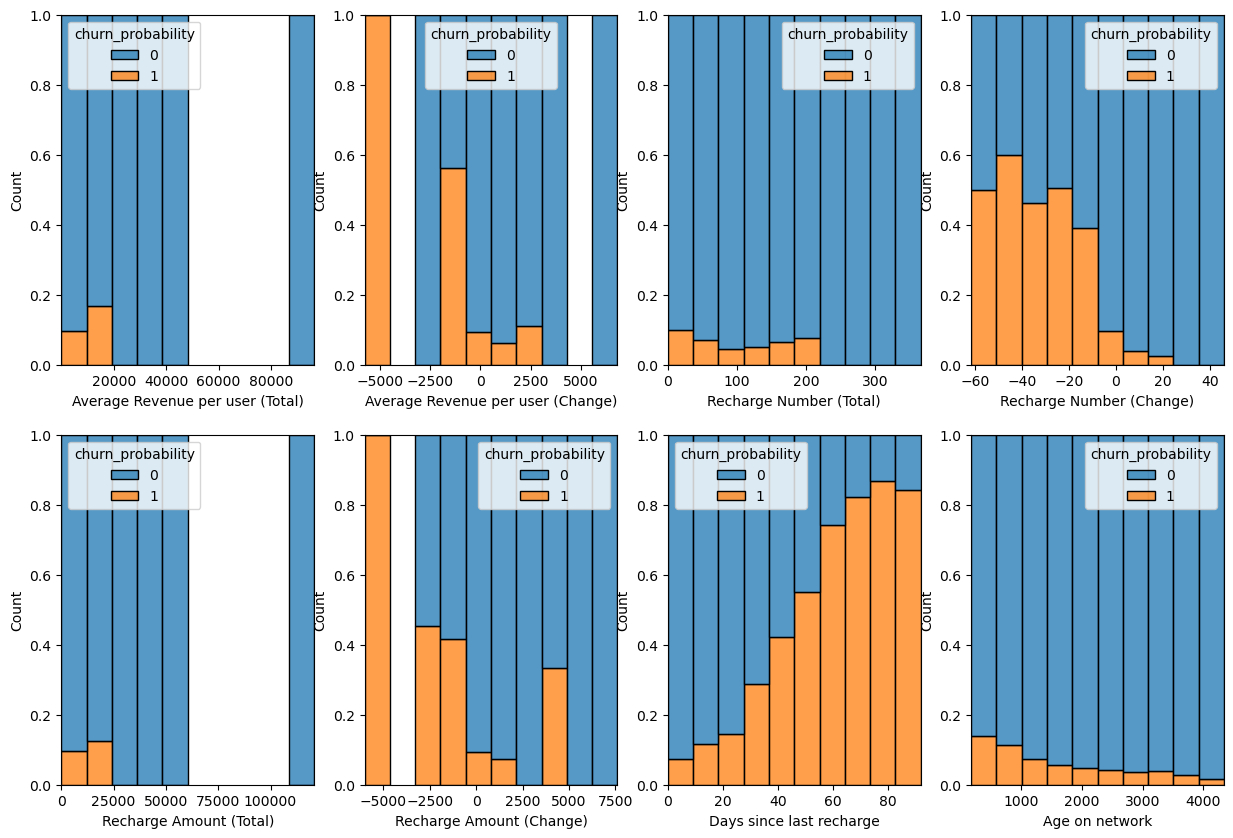

In [42]:
# Draw boxplots for features grouped together for months
'arpu', 'total_rech_num', 'total_rech_amt'

features = [
    {
        "x": "arpu_total",
        "hue": "churn_probability",
        "title": "Average Revenue per user (Total)",
    },
    {
        "x": "arpu_avg_change",
        "hue": "churn_probability",
        "title": "Average Revenue per user (Change)",
    },
    {
        "x": "total_rech_num_total",
        "hue": "churn_probability",
        "title": "Recharge Number (Total)",
    },
    {
        "x": "total_rech_num_avg_change",
        "hue": "churn_probability",
        "title": "Recharge Number (Change)",
    },
    {
        "x": "total_rech_amt_total",
        "hue": "churn_probability",
        "title": "Recharge Amount (Total)",
    },
    {
        "x": "total_rech_amt_avg_change",
        "hue": "churn_probability",
        "title": "Recharge Amount (Change)",
    },
    {
        "x": "days_since_last_rech",
        "hue": "churn_probability",
        "title": "Days since last recharge",
    },
    {
        "x": "aon",
        "hue": "churn_probability",
        "title": "Age on network"
    }
]
draw_hist_plots_with_hue([2, 4], train_data, features)

In [28]:
# Define a function to draw box plots with the given features and choosing colors randomly
def draw_box_plots(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        columns = features[i]["columns"]
        plot = sns.boxplot(data = data.loc[:, columns.keys()], color = random_color())
        plot.set_xticks(list(range(0, len(columns.values()))), columns.values())
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

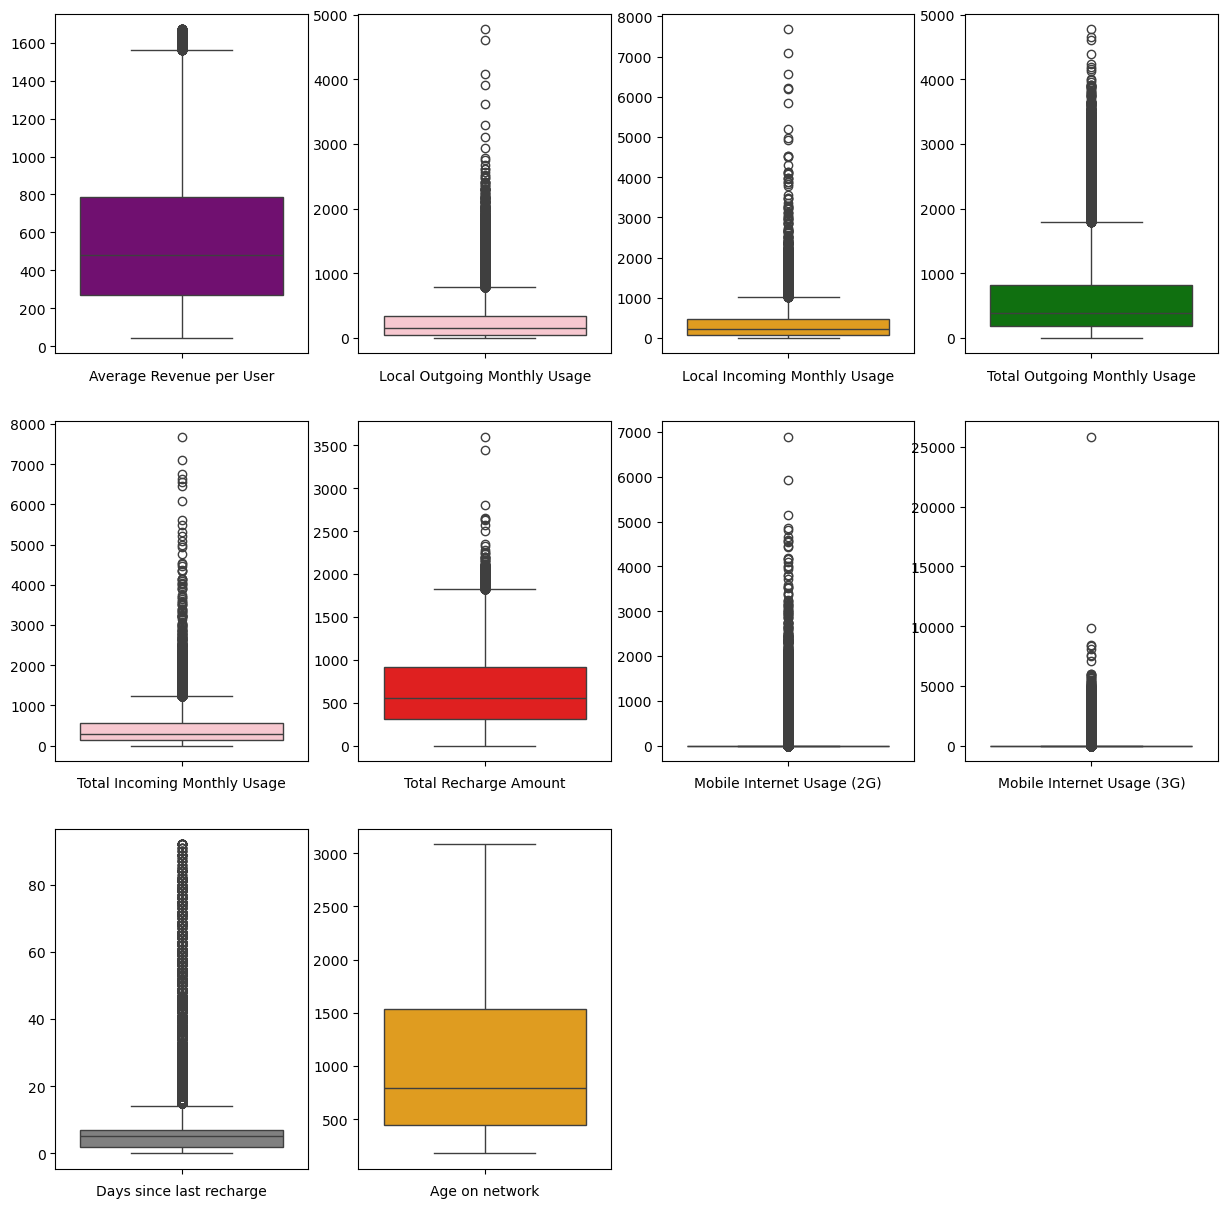

In [66]:
# Draw boxplots for features grouped together for months
features = [
    # {
    #     "columns": { "arpu_6": "June", "arpu_7": "July", "arpu_8": "August" },
    #     "title": "Average Revenue per User"
    # },
    # {
    #     "columns": { "loc_og_mou_6": "June", "loc_og_mou_7": "July", "loc_og_mou_8": "August", },
    #     "title": "Local Outgoing Monthly Usage"
    # },
    # {
    #     "columns": { "loc_ic_mou_6": "June", "loc_ic_mou_7": "July", "loc_ic_mou_8": "August", },
    #     "title": "Local Incoming Monthly Usage"
    # },
    # {
    #     "columns": { "total_og_mou_6": "June", "total_og_mou_7": "July", "total_og_mou_8": "August", },
    #     "title": "Total Outgoing Monthly Usage"
    # },
    # {
    #     "columns": { "total_ic_mou_6": "June", "total_ic_mou_7": "July", "total_ic_mou_8": "August", },
    #     "title": "Total Incoming Monthly Usage"
    # },
    # {
    #     "columns": { "total_rech_amt_6": "June", "total_rech_amt_7": "July", "total_rech_amt_8": "August", },
    #     "title": "Total Recharge Amount"
    # },
    # {
    #     "columns": { "vol_2g_mb_6": "June", "vol_2g_mb_7": "July", "vol_2g_mb_8": "August", },
    #     "title": "Mobile Internet Usage (2G)"
    # },
    # {
    #     "columns": { "vol_3g_mb_6": "June", "vol_3g_mb_7": "July", "vol_3g_mb_8": "August", },
    #     "title": "Mobile Internet Usage (3G)"
    # },
    {
        "columns": { "arpu_total": "" },
        "title": "Average Revenue per User"
    },
    {
        "columns": { "loc_og_mou_total": "", },
        "title": "Local Outgoing Monthly Usage"
    },
    {
        "columns": { "loc_ic_mou_total": "", },
        "title": "Local Incoming Monthly Usage"
    },
    {
        "columns": { "total_og_mou_total": "", },
        "title": "Total Outgoing Monthly Usage"
    },
    {
        "columns": { "total_ic_mou_total": "", },
        "title": "Total Incoming Monthly Usage"
    },
    {
        "columns": { "total_rech_amt_total": "", },
        "title": "Total Recharge Amount"
    },
    {
        "columns": { "vol_2g_mb_total": "", },
        "title": "Mobile Internet Usage (2G)"
    },
    {
        "columns": { "vol_3g_mb_total": "", },
        "title": "Mobile Internet Usage (3G)"
    },
    {
        "columns": { "days_since_last_rech": "" },
        "title": "Days since last recharge"
    },
    {
        "columns": { "aon": "" },
        "title": "Age on network"
    }
]
draw_box_plots([3, 4], train_data, features)

In [24]:
# Removing outliers for various columns where data is beyond 97% quantile
remove_outlier = lambda data, column: data[data[column] < data[column].quantile(0.97)]
columns = ["aon", "arpu_total"]
for column in columns:
    train_data = remove_outlier(train_data, column)

train_data

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_since_last_rech,arpu_total,onnet_mou_total,offnet_mou_total,loc_og_mou_total,std_og_mou_total,isd_og_mou_total,spl_og_mou_total,og_others_total,total_og_mou_total,loc_ic_mou_total,std_ic_mou_total,isd_ic_mou_total,spl_ic_mou_total,ic_others_total,total_ic_mou_total,vol_2g_mb_total,vol_3g_mb_total,monthly_2g_total,sachet_2g_total,monthly_3g_total,sachet_3g_total,total_rech_num_total,total_rech_amt_total
0,65,65,10,2014-06-22,2014-07-10,2014-08-24,65,65,0,1958,0.00,0.00,0.00,0,7,125.813,174.25,131.25,26.18,271.09,0.00,8.83,0.38,306.52,52.73,50.22,0.00,0.66,1.80,105.44,0.00,0.00,0,0,0,0,7,152
1,0,145,50,2014-06-12,2014-07-10,2014-08-26,0,0,0,710,0.00,0.00,0.00,0,5,165.740,0.00,56.88,0.00,0.00,0.00,62.39,0.00,62.39,67.91,0.00,0.00,0.01,0.00,67.92,352.91,3.96,0,0,1,0,12,195
2,70,70,0,2014-06-11,2014-07-22,2014-08-24,70,50,0,882,0.00,0.00,0.00,0,7,163.982,16.46,136.04,37.62,113.93,0.00,4.27,0.00,155.85,155.73,38.77,0.00,0.00,0.25,194.76,0.00,0.00,0,0,0,0,8,190
3,110,110,50,2014-06-15,2014-07-21,2014-08-25,110,110,50,982,0.00,0.00,0.00,0,6,472.717,23.27,197.47,117.38,58.75,0.00,49.69,0.00,225.85,217.13,11.98,0.00,0.00,0.00,229.13,0.00,0.00,0,0,0,0,9,530
4,50,41,30,2014-06-25,2014-07-26,2014-08-30,25,10,30,647,0.00,0.00,0.00,0,1,470.464,32.24,104.73,100.61,4.35,0.00,17.00,0.00,121.96,59.21,0.00,0.00,0.00,0.00,59.21,913.16,0.00,0,19,0,1,31,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,50,110,130,2014-06-18,2014-07-31,2014-08-31,50,20,130,221,0.00,0.00,0.00,0,0,755.820,18.29,870.10,159.95,713.41,0.00,15.88,0.00,889.26,457.75,33.78,0.00,0.00,0.00,491.55,388.90,0.00,0,7,0,1,31,959
69237,90,44,44,2014-06-28,2014-07-31,2014-08-27,50,30,42,712,0.00,0.00,0.00,0,4,714.984,545.63,193.87,207.10,528.19,0.00,4.32,0.00,739.64,170.41,157.66,0.00,0.50,0.08,328.68,0.00,0.00,0,0,0,0,25,821
69238,279,250,349,2014-06-25,2014-07-30,2014-08-29,279,250,48,879,0.00,0.00,0.00,0,2,910.244,224.01,827.32,973.33,24.16,0.21,53.64,0.00,1051.36,1354.97,4.98,5.10,0.00,8.23,1373.30,0.00,0.00,0,0,0,0,8,1273
69239,200,252,145,2014-06-29,2014-07-19,2014-08-26,0,0,0,277,664.25,1402.96,990.97,0,5,629.051,28.36,59.58,57.52,25.86,0.00,0.00,0.00,83.39,29.80,23.01,0.00,0.00,0.00,52.83,148.50,3685.84,0,0,3,0,10,776


In [49]:
# Define a function to draw heatmaps with the given features and choosing colors randomly
def draw_heatmaps(data, features, title):
    fig = plt.figure(figsize = (len(features), len(features) * 0.75))
    # features = [(feat + suffix) for feat in features]
    plot = sns.heatmap(data = data.loc[:, features].corr(), cmap = random_cmap(), annot = True)
    plt.title(title)
    plt.show()

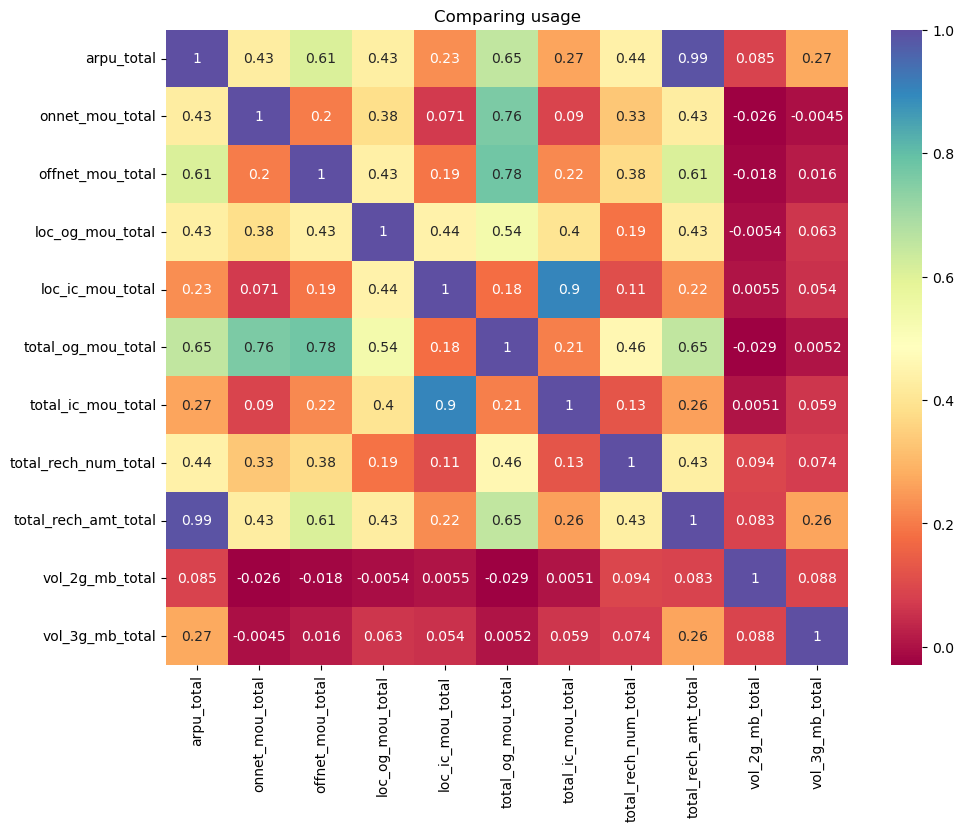

In [52]:
# Draw heatmaps comparing columns for each month separately
columns = ["arpu_total", "onnet_mou_total", "offnet_mou_total", "loc_og_mou_total", "loc_ic_mou_total", "total_og_mou_total", 
           "total_ic_mou_total", "total_rech_num_total", "total_rech_amt_total", "vol_2g_mb_total", "vol_3g_mb_total"]

draw_heatmaps(train_data, columns, "Comparing total usage")

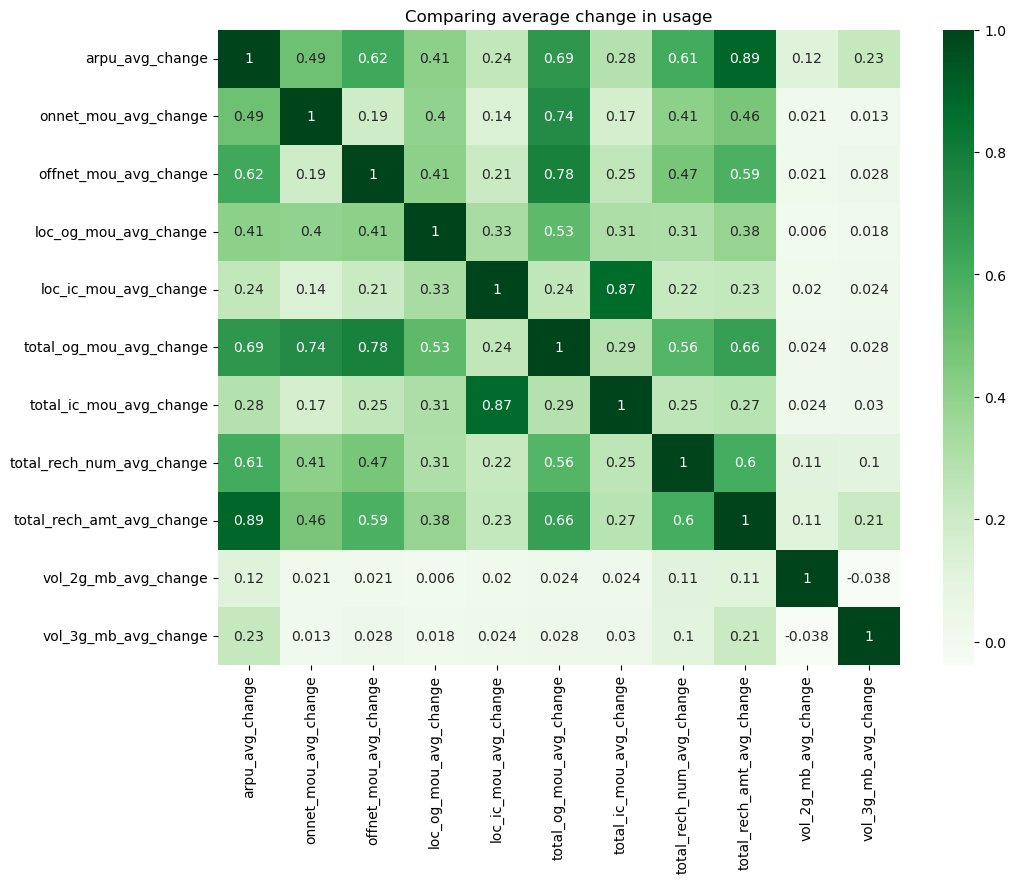

In [56]:
# Draw heatmaps comparing columns for each month separately
columns = ["arpu_avg_change", "onnet_mou_avg_change", "offnet_mou_avg_change", "loc_og_mou_avg_change", "loc_ic_mou_avg_change", 
           "total_og_mou_avg_change", "total_ic_mou_avg_change", "total_rech_num_avg_change", "total_rech_amt_avg_change", 
           "vol_2g_mb_avg_change", "vol_3g_mb_avg_change"]

draw_heatmaps(train_data, columns, "Comparing average change in usage")

In [54]:
# Define a function to draw a pair plot with the given features and choosing colors randomly
def draw_pair_plot(data, features, title):
    plot = sns.pairplot(data, vars=features.keys(), diag_kws={"color": random_color()}, plot_kws={"color": random_color()})
    plot.x_vars = features.values()
    plot.y_vars = features.values()
    plot._add_axis_labels()
    plot.fig.suptitle(title, y=1.03, size=20)

    plt.show()

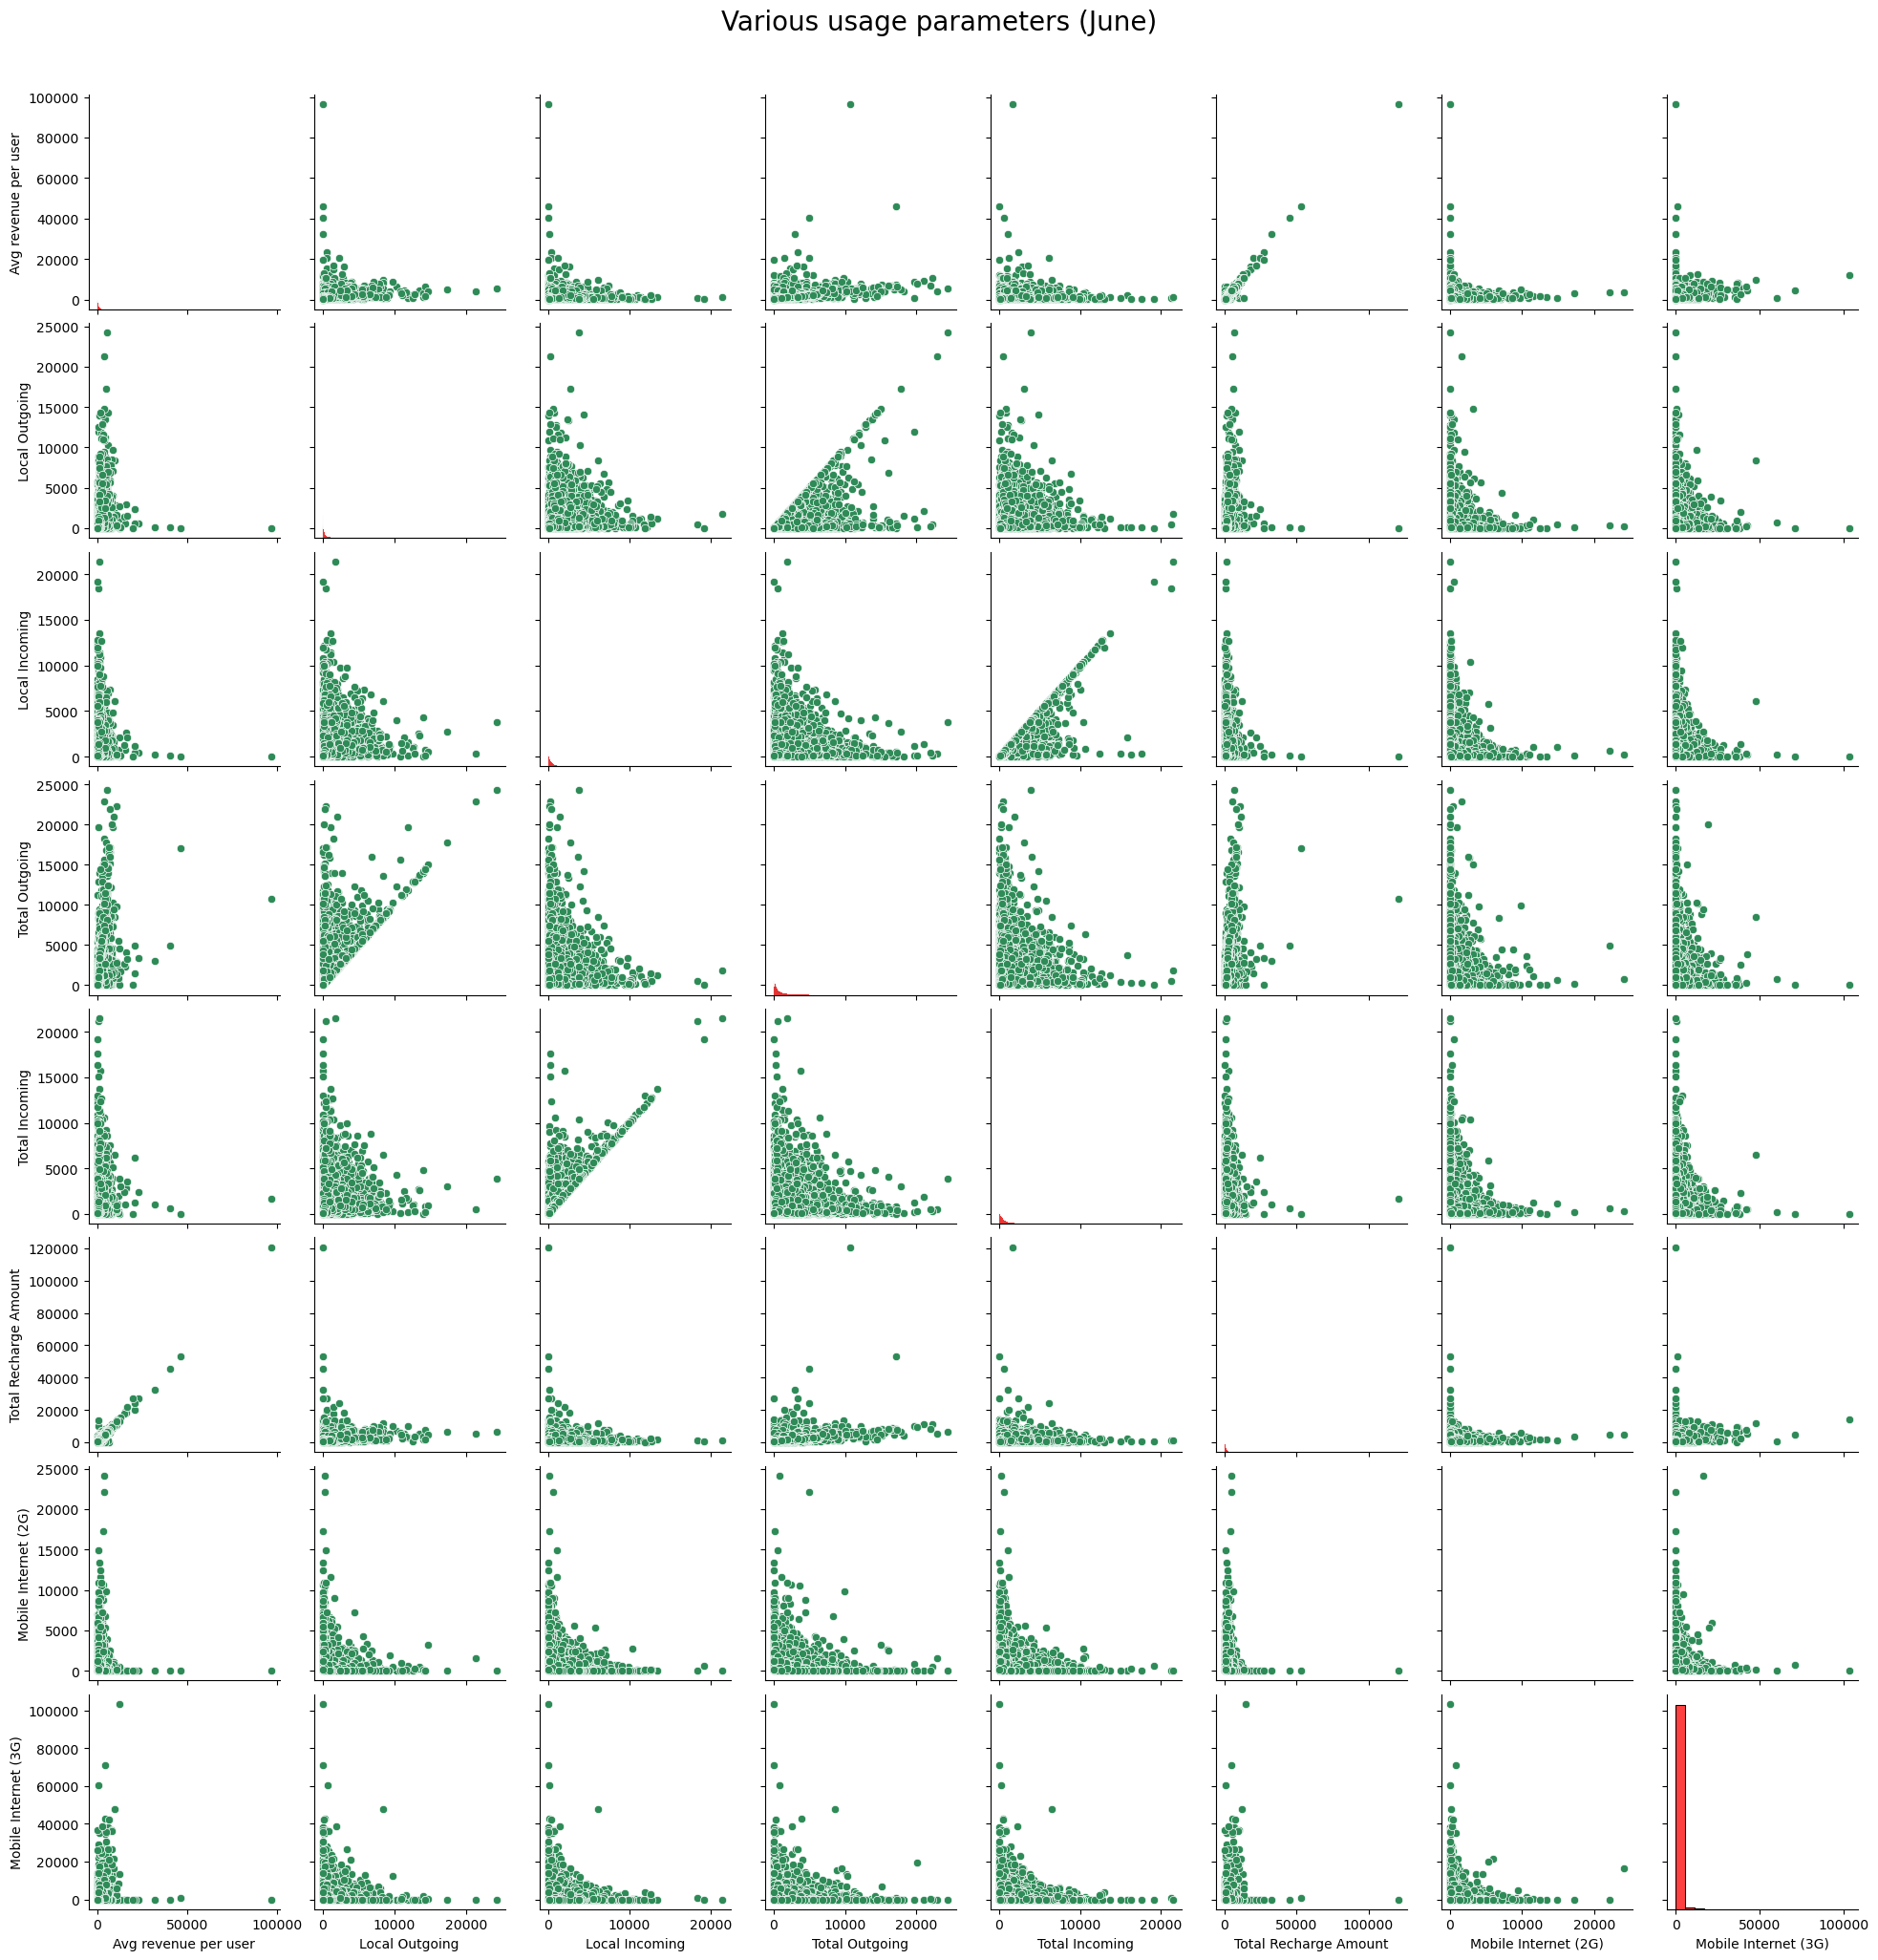

In [55]:
# Pair plot for cnt against calendar parameters like year, weekday etc
features = {
    "arpu_total": "Avg revenue per user", 
    "loc_og_mou_total": "Local Outgoing", 
    "loc_ic_mou_total": "Local Incoming", 
    "total_og_mou_total": "Total Outgoing", 
    "total_ic_mou_total": "Total Incoming", 
    "total_rech_amt_total": "Total Recharge Amount", 
    "vol_2g_mb_total": "Mobile Internet (2G)", 
    "vol_3g_mb_total": "Mobile Internet (3G)"
}

draw_pair_plot(train_data, features, "Various usage parameters (June)")

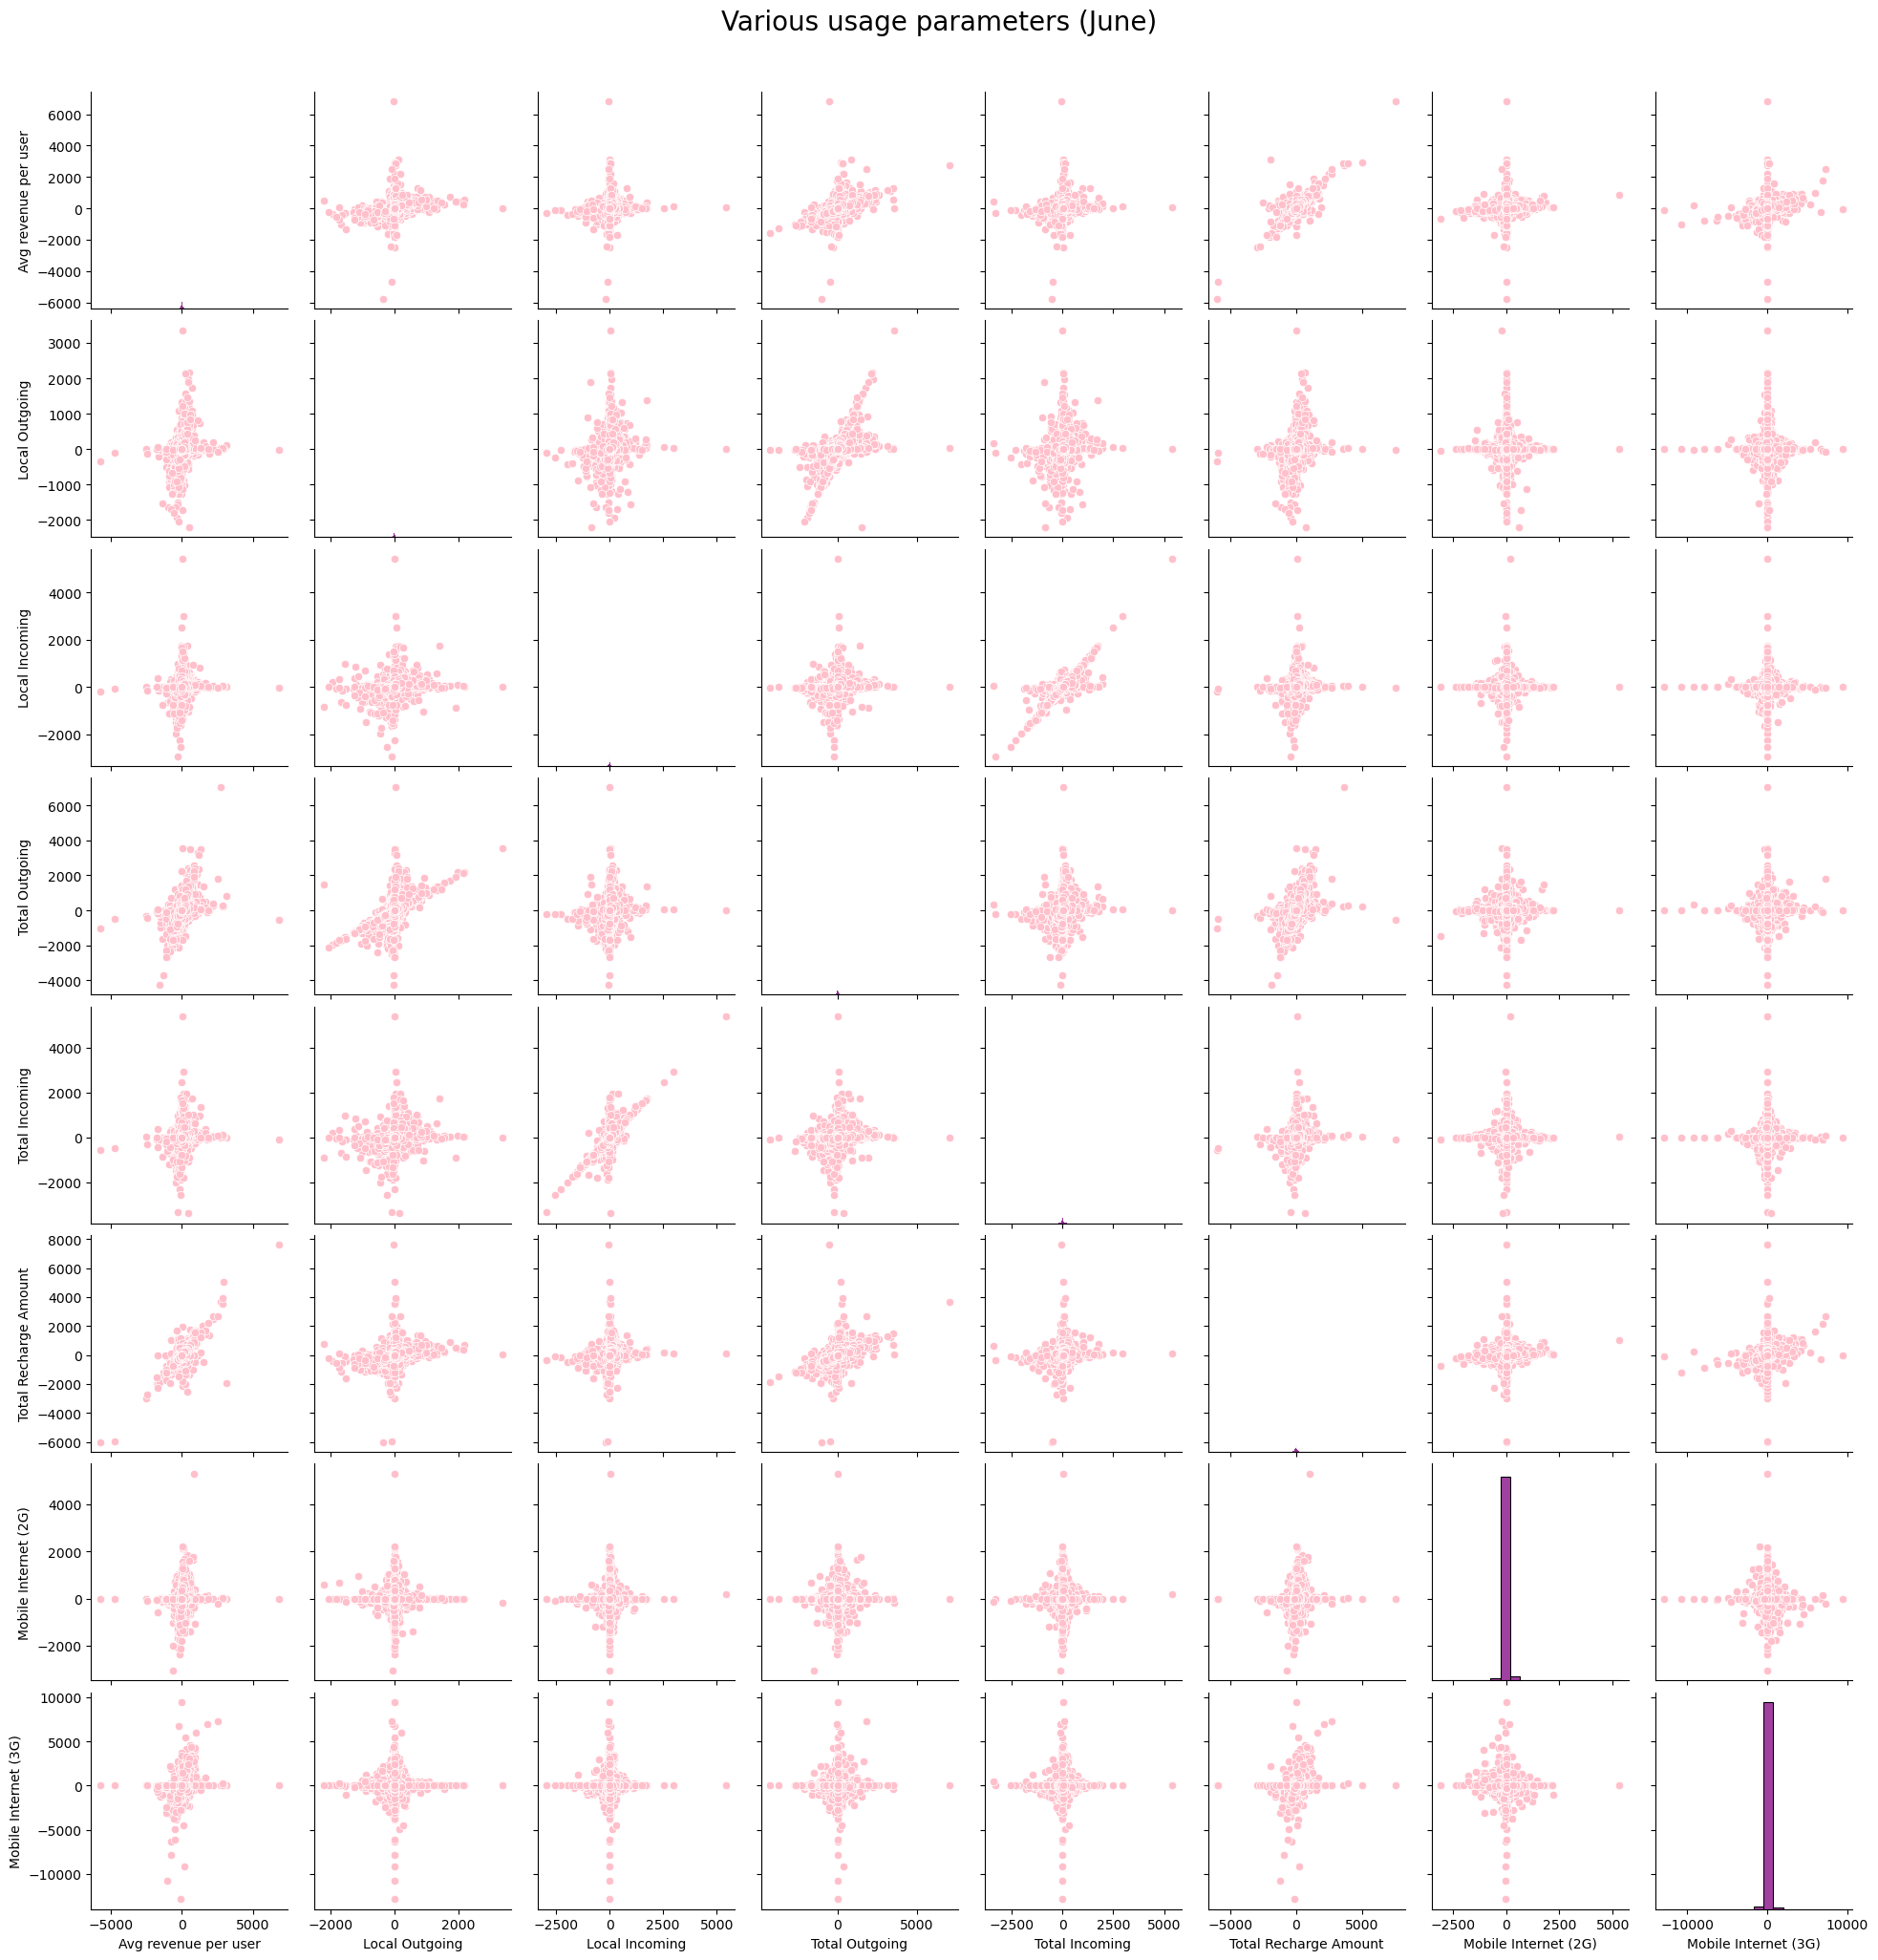

In [57]:
# Pair plot for cnt against calendar parameters like year, weekday etc
features = {
    "arpu_avg_change": "Avg revenue per user", 
    "loc_og_mou_avg_change": "Local Outgoing", 
    "loc_ic_mou_avg_change": "Local Incoming", 
    "total_og_mou_avg_change": "Total Outgoing", 
    "total_ic_mou_avg_change": "Total Incoming", 
    "total_rech_amt_avg_change": "Total Recharge Amount", 
    "vol_2g_mb_avg_change": "Mobile Internet (2G)", 
    "vol_3g_mb_avg_change": "Mobile Internet (3G)"
}

draw_pair_plot(train_data, features, "Various usage parameters (June)")

# Data Preparation

In [25]:
# Remove non-numeric columns from training data
final_train_data = train_data.drop(["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"], axis=1)
final_train_data

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,days_since_last_rech,arpu_total,arpu_avg_change,onnet_mou_avg_change,offnet_mou_avg_change,loc_og_mou_avg_change,std_og_mou_avg_change,isd_og_mou_avg_change,spl_og_mou_avg_change,og_others_avg_change,total_og_mou_avg_change,loc_ic_mou_avg_change,std_ic_mou_avg_change,isd_ic_mou_avg_change,spl_ic_mou_avg_change,ic_others_avg_change,total_ic_mou_avg_change,vol_2g_mb_avg_change,vol_3g_mb_avg_change,monthly_2g_avg_change,sachet_2g_avg_change,monthly_3g_avg_change,sachet_3g_avg_change,total_rech_num_avg_change,total_rech_amt_avg_change
0,65,65,10,65,65,0,1958,0.00,0.00,0.00,0,7,125.813,-11.8750,-23.645,-14.955,-2.460,-32.040,0.000,-4.100,-0.19,-38.790,10.725,3.860,0.000,0.330,-0.555,14.360,0.000,0.00,0.0,0.0,0.0,0.0,-0.5,-33.5
1,0,145,50,0,0,0,710,0.00,0.00,0.00,0,5,165.740,21.4765,0.000,15.445,0.000,0.000,0.000,15.830,0.00,15.830,10.795,0.000,0.000,0.005,0.000,10.800,0.000,0.00,0.0,0.0,0.0,0.0,1.0,25.0
2,70,70,0,70,50,0,882,0.00,0.00,0.00,0,7,163.982,-30.4030,-0.265,-26.995,-12.320,-14.470,0.000,-1.445,0.00,-28.245,-32.185,-11.765,0.000,0.000,0.125,-43.825,0.000,0.00,0.0,0.0,0.0,0.0,0.0,-35.0
3,110,110,50,110,110,50,982,0.00,0.00,0.00,0,6,472.717,-22.6335,-3.630,-9.265,-10.640,-5.780,0.000,5.330,0.00,-11.095,-2.590,-3.040,0.000,0.000,0.000,-5.635,0.000,0.00,0.0,0.0,0.0,0.0,0.5,-15.0
4,50,41,30,25,10,30,647,0.00,0.00,0.00,0,1,470.464,-69.5715,-7.575,-23.680,-21.575,-2.175,0.000,0.000,0.00,-23.750,3.385,0.000,0.000,0.000,0.000,3.385,-88.665,0.00,0.0,-0.5,0.0,0.0,-2.5,-84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,50,110,130,50,20,130,221,0.00,0.00,0.00,0,0,755.820,156.6880,5.465,190.820,48.430,146.940,0.000,0.915,0.00,196.290,128.880,5.895,0.000,0.000,0.000,134.780,72.155,0.00,0.0,0.5,0.0,0.0,6.0,231.0
69237,90,44,44,50,30,42,712,0.00,0.00,0.00,0,4,714.984,52.8445,58.045,-0.735,4.840,52.375,0.000,0.025,0.00,57.240,-1.375,28.970,0.000,0.250,0.040,27.885,0.000,0.00,0.0,0.0,0.0,0.0,2.0,54.0
69238,279,250,349,279,250,48,879,0.00,0.00,0.00,0,2,910.244,-46.1530,0.655,-35.850,-10.310,0.000,-0.105,-24.770,0.00,-35.195,-58.735,-0.010,-2.500,0.000,-2.570,-63.820,0.000,0.00,0.0,0.0,0.0,0.0,0.5,-114.5
69239,200,252,145,0,0,0,277,664.25,1402.96,990.97,0,5,629.051,-46.7565,-3.650,-8.890,-2.450,-7.800,0.000,0.000,0.00,-10.250,-2.285,1.750,0.000,0.000,0.000,-0.535,-0.805,-297.64,0.0,0.0,0.0,0.0,-1.5,-117.0


In [26]:
# Separate data into feature and target set
y_train_data = final_train_data.pop("churn_probability")
X_train_data = final_train_data

# Print top 5 records from feature training set
X_train_data.head()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,days_since_last_rech,arpu_total,arpu_avg_change,onnet_mou_avg_change,offnet_mou_avg_change,loc_og_mou_avg_change,std_og_mou_avg_change,isd_og_mou_avg_change,spl_og_mou_avg_change,og_others_avg_change,total_og_mou_avg_change,loc_ic_mou_avg_change,std_ic_mou_avg_change,isd_ic_mou_avg_change,spl_ic_mou_avg_change,ic_others_avg_change,total_ic_mou_avg_change,vol_2g_mb_avg_change,vol_3g_mb_avg_change,monthly_2g_avg_change,sachet_2g_avg_change,monthly_3g_avg_change,sachet_3g_avg_change,total_rech_num_avg_change,total_rech_amt_avg_change
0,65,65,10,65,65,0,1958,0.0,0.0,0.0,7,125.813,-11.8750,-23.645,-14.955,-2.460,-32.040,0.0,-4.100,-0.19,-38.790,10.725,3.860,0.0,0.330,-0.555,14.360,0.000,0.0,0.0,0.0,0.0,0.0,-0.5,-33.5
1,0,145,50,0,0,0,710,0.0,0.0,0.0,5,165.740,21.4765,0.000,15.445,0.000,0.000,0.0,15.830,0.00,15.830,10.795,0.000,0.0,0.005,0.000,10.800,0.000,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,70,70,0,70,50,0,882,0.0,0.0,0.0,7,163.982,-30.4030,-0.265,-26.995,-12.320,-14.470,0.0,-1.445,0.00,-28.245,-32.185,-11.765,0.0,0.000,0.125,-43.825,0.000,0.0,0.0,0.0,0.0,0.0,0.0,-35.0
3,110,110,50,110,110,50,982,0.0,0.0,0.0,6,472.717,-22.6335,-3.630,-9.265,-10.640,-5.780,0.0,5.330,0.00,-11.095,-2.590,-3.040,0.0,0.000,0.000,-5.635,0.000,0.0,0.0,0.0,0.0,0.0,0.5,-15.0
4,50,41,30,25,10,30,647,0.0,0.0,0.0,1,470.464,-69.5715,-7.575,-23.680,-21.575,-2.175,0.0,0.000,0.00,-23.750,3.385,0.000,0.0,0.000,0.000,3.385,-88.665,0.0,0.0,-0.5,0.0,0.0,-2.5,-84.0


In [27]:
# Rescale all features using Standard Scaler, use columns which are numeric
scaler = StandardScaler()
X_train_data[X_train_data.columns] = scaler.fit_transform(X_train_data[X_train_data.columns])

# Print first 5 rows of training set
X_train_data.head()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,days_since_last_rech,arpu_total,arpu_avg_change,onnet_mou_avg_change,offnet_mou_avg_change,loc_og_mou_avg_change,std_og_mou_avg_change,isd_og_mou_avg_change,spl_og_mou_avg_change,og_others_avg_change,total_og_mou_avg_change,loc_ic_mou_avg_change,std_ic_mou_avg_change,isd_ic_mou_avg_change,spl_ic_mou_avg_change,ic_others_avg_change,total_ic_mou_avg_change,vol_2g_mb_avg_change,vol_3g_mb_avg_change,monthly_2g_avg_change,sachet_2g_avg_change,monthly_3g_avg_change,sachet_3g_avg_change,total_rech_num_avg_change,total_rech_amt_avg_change
0,-0.325555,-0.326035,-0.788829,0.019834,0.060498,-0.615206,0.768962,-0.254588,-0.246371,-0.233242,0.020493,-0.770117,-0.070095,-0.166993,-0.084692,0.001639,-0.178266,0.001353,-0.514908,0.007331,-0.171069,0.124295,0.077538,-0.014333,3.333730,-0.105548,0.128833,0.007084,-0.029982,-0.005616,-0.042449,-0.020486,-0.01597,-0.094666,-0.176976
1,-0.864311,0.340145,-0.465843,-0.650543,-0.624918,-0.615206,-0.539894,-0.254588,-0.246371,-0.233242,-0.186112,-0.727353,0.159859,0.007242,0.121341,0.028990,-0.007213,0.001353,1.719206,0.081622,0.076055,0.125026,-0.002584,-0.014333,0.153905,-0.008158,0.098214,0.007084,-0.029982,-0.005616,-0.042449,-0.020486,-0.01597,0.332048,0.149455
2,-0.284112,-0.284399,-0.869575,0.071401,-0.097675,-0.615206,-0.359507,-0.254588,-0.246371,-0.233242,0.020493,-0.729236,-0.197843,0.005289,-0.166291,-0.107988,-0.084465,0.001353,-0.217288,0.081622,-0.123359,-0.323487,-0.246790,-0.014333,0.104984,0.013777,-0.371611,0.007084,-0.029982,-0.005616,-0.042449,-0.020486,-0.01597,0.047572,-0.185346
3,0.047430,0.048691,-0.465843,0.483941,0.535017,-0.123096,-0.254631,-0.254588,-0.246371,-0.233242,-0.082810,-0.398560,-0.144273,-0.019507,-0.046128,-0.089309,-0.038071,0.001353,0.542177,0.081622,-0.045765,-0.014652,-0.065685,-0.014333,0.104984,-0.008158,-0.043142,0.007084,-0.029982,-0.005616,-0.042449,-0.020486,-0.01597,0.189810,-0.073746
4,-0.449883,-0.525889,-0.627336,-0.392706,-0.519470,-0.319940,-0.605966,-0.254588,-0.246371,-0.233242,-0.599323,-0.400973,-0.467904,-0.048577,-0.143824,-0.210889,-0.018825,0.001353,-0.055306,0.081622,-0.103022,0.047700,-0.002584,-0.014333,0.104984,-0.008158,0.034438,-0.817391,-0.029982,-0.005616,-0.733707,-0.020486,-0.01597,-0.663618,-0.458767


In [28]:
# Initialize PCA and create 25 components
pca = PCA(n_components = 25, random_state = 42)
pca_components = pca.fit_transform(X_train_data)
pca.components_

array([[ 2.20855071e-01,  2.32369534e-01,  2.32826195e-01,
         1.81233288e-01,  1.89790700e-01,  1.83750391e-01,
         4.13040294e-02,  1.27380553e-01,  1.29980250e-01,
         1.19354795e-01, -7.03355412e-02,  3.66122952e-01,
         2.03911513e-01,  2.60475272e-01,  2.32395914e-01,
         1.94808689e-01,  3.01395454e-02,  5.01561485e-02,
         1.14650469e-02,  3.01747391e-01,  1.42478186e-01,
         7.58329264e-02,  3.35939765e-02, -2.79369333e-02,
         1.96854526e-02,  1.57611902e-01,  4.57748811e-02,
         1.39584535e-01,  8.82540732e-02,  1.22287423e-02,
         1.30134239e-01,  3.44196027e-02,  1.32189941e-01,
         3.71525574e-01],
       [ 1.41798329e-01,  1.29962447e-01,  1.26616575e-01,
         9.61753533e-02,  6.68791794e-02,  9.12585704e-02,
         5.28262628e-02,  3.24623273e-01,  3.38126341e-01,
         3.19497853e-01,  8.42019573e-02, -9.77934951e-02,
        -2.29393337e-01, -2.10479491e-01, -7.59330324e-02,
        -2.86786365e-01,  1.27

In [41]:
# Select the top 10 components for use in model building
selected_components = 10
pca_X_train_data = pca_components[:, :selected_components]

# Model Building

In [32]:
# Define a function to print various metrics comparing the actual and prediction
model_metrics = pd.DataFrame(columns = ["model", "parameters", "confusion_matrix", "accuracy_score", "precision_score", "recall_score"])

def print_metrics(model, parameters, actual, prediction, model_metrics):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    print("Confusion Matrix = \n", confusion_matrix)

    accuracy_score = round(metrics.accuracy_score(actual, prediction), 2)
    print("Accuracy score =", accuracy_score)

    precision_score = round(metrics.precision_score(actual, prediction), 2)
    print("Precision score = ", precision_score)

    recall_score = round(metrics.recall_score(actual, prediction), 2)
    print("Recall score = ", recall_score)

    model_metrics.loc[len(model_metrics)] = (model, parameters, confusion_matrix, accuracy_score, precision_score, recall_score)
    return model_metrics

## Logistic Regression

In [28]:
# Initialize Logistic Regression model, and select features using RFE in a GridSearch
# Parameters to tune: n_features_to_select
logistic_rfe = RFE(estimator = LogisticRegression(),
                   n_features_to_select = 15,
                   verbose = True)

logistic_rfe.fit(X_train_data, y_train_data)

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.


RFE(estimator=LogisticRegression(), n_features_to_select=15, verbose=True)

In [29]:
# Print the wieghtage of each column after RFE and store the selected columns
selected_columns = X_train_data.columns[logistic_rfe.support_]
list(zip(X_train_data.columns, logistic_rfe.support_, logistic_rfe.ranking_))

[('max_rech_amt_6', False, 11),
 ('max_rech_amt_7', False, 2),
 ('max_rech_amt_8', True, 1),
 ('last_day_rch_amt_6', False, 13),
 ('last_day_rch_amt_7', False, 3),
 ('last_day_rch_amt_8', True, 1),
 ('aon', True, 1),
 ('aug_vbc_3g', True, 1),
 ('jul_vbc_3g', False, 8),
 ('jun_vbc_3g', False, 17),
 ('days_since_last_rech', True, 1),
 ('arpu_total', True, 1),
 ('arpu_avg_change', True, 1),
 ('onnet_mou_avg_change', True, 1),
 ('offnet_mou_avg_change', True, 1),
 ('loc_og_mou_avg_change', False, 10),
 ('std_og_mou_avg_change', True, 1),
 ('isd_og_mou_avg_change', False, 18),
 ('spl_og_mou_avg_change', False, 5),
 ('og_others_avg_change', False, 6),
 ('total_og_mou_avg_change', True, 1),
 ('loc_ic_mou_avg_change', False, 4),
 ('std_ic_mou_avg_change', False, 14),
 ('isd_ic_mou_avg_change', False, 15),
 ('spl_ic_mou_avg_change', False, 7),
 ('ic_others_avg_change', False, 21),
 ('total_ic_mou_avg_change', True, 1),
 ('vol_2g_mb_avg_change', False, 12),
 ('vol_3g_mb_avg_change', False, 16),


In [30]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = logistic_rfe.predict(X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'churn_probability': y_train_data_pred, 'id': y_train_data.index })
y_train_data_pred['prediction'] = y_train_data_pred.churn_probability.map(lambda prob: 1 if prob > 0.5 else 0)
y_train_data_pred

,churn,churn_probability,id,prediction
0,0,0,0,0
1,0,0,1,0
2,0,0,2,0
3,0,0,3,0
4,0,0,4,0
...,...,...,...,...
69236,0,0,69236,0
69237,0,0,69237,0
69238,0,0,69238,0
69239,0,0,69239,0


In [33]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression with RFE', 
                              {'n_features_to_select': logistic_rfe.n_features_to_select}, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[62015   633]
 [ 5315  1278]]
Accuracy score = 0.91
Precision score =  0.67
Recall score =  0.19


## Random Forest

In [43]:
# Initialize Random Forest model in a GridSearch
# Parameters to tune: n_estimators, max_depth, max_features, min_samples_leaf

params = {
    "n_estimators": [50, 75, 100],
    "max_depth": [7, 10, 12],
    "max_features": [10, 12, 15],
    "min_samples_leaf": [20, 25, 35]
}
grid_search_random_forest = GridSearchCV(estimator = RandomForestClassifier(verbose = True),
                                  param_grid = params, 
                                  cv = 4, 
                                  n_jobs = -1, 
                                  scoring = "accuracy", 
                                  verbose = True)
grid_search_random_forest.fit(X_train_data, y_train_data)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

GridSearchCV(cv=4, estimator=RandomForestClassifier(verbose=True), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12], 'max_features': [10, 12, 15],
                         'min_samples_leaf': [20, 25, 35],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy', verbose=True)

In [44]:
# Print the best score, parameters and model obtained from grid search
print("Best Score =", grid_search_random_forest.best_score_)
print("Best Parameters =", grid_search_random_forest.best_params_)
random_forest = grid_search_random_forest.best_estimator_
random_forest

Best Score = 0.9248326886473874
Best Parameters = {'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 20, 'n_estimators': 75}


RandomForestClassifier(max_depth=10, max_features=15, min_samples_leaf=20,
                       n_estimators=75, verbose=True)

In [45]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = random_forest.predict(X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'id': y_train_data.index, 'prediction': y_train_data_pred })
y_train_data_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


,churn,id,prediction
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
65143,0,69236,0
65144,0,69237,0
65145,0,69238,0
65146,0,69239,0


In [49]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Random Forest', 
                              grid_search_random_forest.best_params_, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[57680  1059]
 [ 3381  3028]]
Accuracy score = 0.93
Precision score =  0.74
Recall score =  0.47


## XGBoost Regressor

In [97]:
# Initialize XGBoost Classifier model in a GridSearch
# Parameters to tune: n_estimators, learning_rate, min_child_weight, gamma, max_depth

params = {
    "n_estimators": [25, 50, 75, 100],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.05, 0.1, 0.2],
    "gamma": [0.25, 0.5, 1],
    "min_child_weight": [1, 5, 7]
}
random_search_xgb = RandomizedSearchCV(estimator = xgb.XGBClassifier(),
                                       param_distributions = params,
                                       cv = 4,
                                       n_iter = 1000,
                                       n_jobs = -1,
                                       scoring = "accuracy",
                                       verbose = True)
random_search_xgb.fit(X_train_data, y_train_data)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'gamma': [0.25, 0.5, 1],
                                        'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [7, 10, 15],
                                        'min_child_weight': [1, 5, 7],
                                        'n_estimators': [25, 50, 75, 100]},
                   scoring='accuracy', verbose=True)

In [98]:
# Print the best score, parameters and model obtained from random search
print("Best Score =", random_search_xgb.best_score_)
print("Best Parameters =", random_search_xgb.best_params_)
xg_boost = random_search_xgb.best_estimator_
xg_boost

Best Score = 0.9336385743597538
Best Parameters = {'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.25}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [99]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = xg_boost.predict(X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'id': y_train_data.index, 'prediction': y_train_data_pred })
y_train_data_pred

,churn,id,prediction
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
52631,0,69235,0
52632,0,69236,0
52633,0,69237,0
52634,0,69238,0


In [100]:
# Print metrics and add them to data frame for comparison
model_metrics = print_metrics('XGBoost', 
                              random_search_xgb.best_params_, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[45338  1130]
 [ 1786  4382]]
Accuracy score = 0.94
Precision score =  0.79
Recall score =  0.71


## PCA + Logistic Regression

In [127]:
# Initialize logistic regression and fit with PCA transformed data
pca_logistic = LogisticRegression()
pca_logistic.fit(pca_X_train_data, y_train_data)

LogisticRegression()

In [128]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = pca_logistic.predict(pca_X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'prediction': y_train_data_pred, 'id': y_train_data.index })
y_train_data_pred

,churn,prediction,id
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4
...,...,...,...
52631,0,0,69235
52632,0,0,69236
52633,0,0,69237
52634,0,0,69238


In [129]:
# Print metrics and add them to dataframe for comparison
model_metrics = print_metrics('Logistic Regression with PCA', 
                              {'n_components': pca.n_components, 'selected_components': selected_components}, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[45787   681]
 [ 4703  1465]]
Accuracy score = 0.9
Precision score =  0.68
Recall score =  0.24


## PCA + Random Forest

In [150]:
# Initialize Random Forest model in a GridSearch
# Parameters to tune: n_estimators, max_depth, max_features, min_samples_leaf
params = {
    "n_estimators": [50, 75, 100],
    "max_depth": [5, 7, 10],
    "max_features": [5, 10, 12],
    "min_samples_leaf": [20, 25, 35]
}
grid_search_random_forest = GridSearchCV(estimator = RandomForestClassifier(verbose = True),
                                  param_grid = params, 
                                  cv = 4, 
                                  n_jobs = -1, 
                                  scoring = "accuracy", 
                                  verbose = True)
grid_search_random_forest.fit(pca_X_train_data, y_train_data)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

GridSearchCV(cv=4, estimator=RandomForestClassifier(verbose=True), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12], 'max_features': [10, 12, 15],
                         'min_samples_leaf': [20, 25, 35],
                         'n_estimators': [50, 75, 100]},
             scoring='accuracy', verbose=True)

In [156]:
# Print the best score, parameters and model obtained from grid search
print("Best Score =", grid_search_random_forest.best_score_)
print("Best Parameters =", grid_search_random_forest.best_params_)
pca_random_forest = grid_search_random_forest.best_estimator_
pca_random_forest

Best Score = 0.9083516984573297
Best Parameters = {'max_depth': 12, 'max_features': 12, 'min_samples_leaf': 20, 'n_estimators': 75}


RandomForestClassifier(max_depth=12, max_features=12, min_samples_leaf=20,
                       n_estimators=75, verbose=True)

In [157]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = pca_random_forest.predict(pca_X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'prediction': y_train_data_pred, 'id': y_train_data.index })
y_train_data_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


,churn,prediction,id
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4
...,...,...,...
52631,0,0,69235
52632,0,0,69236
52633,0,0,69237
52634,0,0,69238


In [168]:
# Print metrics and add them to dataframe for comparison
parameters = grid_search_random_forest.best_params_
parameters['n_components'] = pca.n_components
model_metrics = print_metrics('Random Forest with PCA', 
                              parameters, 
                              y_train_data_pred.churn, 
                              y_train_data_pred.prediction, 
                              model_metrics)

Confusion Matrix = 
 [[45541   927]
 [ 2903  3265]]
Accuracy score = 0.93
Precision score =  0.78
Recall score =  0.53


# Model Selection

In [34]:
model_metrics

,model,parameters,confusion_matrix,accuracy_score,precision_score,recall_score
0,Logistic Regression with RFE,{'n_features_to_select': 15},"[[62015, 633], [5315, 1278]]",0.91,0.67,0.19


In [51]:
final_model = random_forest
isPCA = False

# Evaluation and Prediction

In [36]:
test_data = fill_data(test_data)
test_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.00,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.00,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.00,0.00,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.00,0.00,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.00,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.00,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.00,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.00,0.00,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.00,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/201

In [37]:
test_data = create_and_modify_columns(test_data)
test_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,days_since_last_rech,arpu_total,onnet_mou_total,offnet_mou_total,loc_og_mou_total,std_og_mou_total,isd_og_mou_total,spl_og_mou_total,og_others_total,total_og_mou_total,loc_ic_mou_total,std_ic_mou_total,isd_ic_mou_total,spl_ic_mou_total,ic_others_total,total_ic_mou_total,vol_2g_mb_total,vol_3g_mb_total,monthly_2g_total,sachet_2g_total,monthly_3g_total,sachet_3g_total,total_rech_num_total,total_rech_amt_total
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.00,0.00,0.03,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.00,0.0,0.0,0.0,0.0,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,0.00,0.00,0.00,0.36,1.04,4.34,0.00,0.00,0.00,0.0,0.0,0.0,50,30,30,2014-06-21,2014-07-26,2014-08-24,30,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1692,0.00,0.00,0.00,7,221.657,75.12,127.15,117.15,85.09,0.00,0.03,0.0,202.27,114.48,5.74,0.00,1.27,0.00,121.55,0.00,0.00,0,0,0,0,14,253
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.00,0.0,0.0,0.0,0.0,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,0.00,0.00,0.00,0.00,12.51,0.00,0.00,0.00,0.00,0.0,0.0,0.0,250,250,250,2014-06-19,2014-07-16,2014-08-24,250,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2533,0.00,0.00,0.00,7,1290.604,136.56,1491.12,1586.26,41.44,0.80,0.00,0.0,1628.51,518.36,12.51,386.74,0.00,0.00,917.63,0.00,0.00,0,0,0,0,14,1500
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,22.81,103.38,26.08,24.53,53.68,54.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,300,500,500,2014-06-29,2014-07-27,2014-08-28,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,277,525.61,758.41,241.84,3,1510.967,23.80,107.83,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,20,2500
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.00,0.00,0.00,0.00,0.0

In [38]:
# Create test data as per the final training data columns
X_test_data = test_data.loc[:, final_train_data.columns]

# Print top 5 records from feature testing set
X_test_data.head()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,days_since_last_rech,arpu_total,onnet_mou_total,offnet_mou_total,loc_og_mou_total,std_og_mou_total,isd_og_mou_total,spl_og_mou_total,og_others_total,total_og_mou_total,loc_ic_mou_total,std_ic_mou_total,isd_ic_mou_total,spl_ic_mou_total,ic_others_total,total_ic_mou_total,vol_2g_mb_total,vol_3g_mb_total,monthly_2g_total,sachet_2g_total,monthly_3g_total,sachet_3g_total,total_rech_num_total,total_rech_amt_total
0,50,30,30,30,30,0,1692,0.00,0.00,0.00,7,221.657,75.12,127.15,117.15,85.09,0.0,0.03,0.0,202.27,114.48,5.74,0.00,1.27,0.00,121.55,0.0,0.0,0,0,0,0,14,253
1,250,250,250,250,0,0,2533,0.00,0.00,0.00,7,1290.604,136.56,1491.12,1586.26,41.44,0.8,0.00,0.0,1628.51,518.36,12.51,386.74,0.00,0.00,917.63,0.0,0.0,0,0,0,0,14,1500
2,300,500,500,0,0,0,277,525.61,758.41,241.84,3,1510.967,23.80,107.83,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0,0,0,0,20,2500
3,110,150,0,110,150,0,1244,0.00,0.00,0.00,7,239.340,7.47,269.06,129.73,133.62,0.0,13.18,0.0,276.55,1582.56,34.60,10.08,0.00,0.00,1627.26,0.0,0.0,0,0,0,0,10,370
4,90,130,130,50,130,130,462,0.00,0.00,0.00,1,1126.472,1760.64,158.94,31.79,1887.75,0.0,11.06,2.2,1932.85,37.33,291.40,0.00,0.00,0.16,328.92,0.0,0.0,0,0,0,0,26,1392


In [39]:
# Scale test data using earlier fitted scaler
X_test_data[X_test_data.columns] = scaler.transform(X_test_data[X_test_data.columns])

# Print first 5 rows of training set
X_test_data.head()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,days_since_last_rech,arpu_total,onnet_mou_total,offnet_mou_total,loc_og_mou_total,std_og_mou_total,isd_og_mou_total,spl_og_mou_total,og_others_total,total_og_mou_total,loc_ic_mou_total,std_ic_mou_total,isd_ic_mou_total,spl_ic_mou_total,ic_others_total,total_ic_mou_total,vol_2g_mb_total,vol_3g_mb_total,monthly_2g_total,sachet_2g_total,monthly_3g_total,sachet_3g_total,total_rech_num_total,total_rech_amt_total
0,-0.465297,-0.653528,-0.661110,-0.344480,-0.302028,-0.635211,0.619080,-0.263774,-0.249961,-0.234624,0.011533,-0.931337,-0.411699,-0.585402,-0.442813,-0.431829,-0.069746,-0.303942,-0.077472,-0.635829,-0.517680,-0.312067,-0.133868,3.728849,-0.084308,-0.586974,-0.290522,-0.284003,-0.327378,-0.307699,-0.242304,-0.156972,-0.468425,-0.911687
1,1.506694,1.504942,1.416309,2.289191,-0.670854,-0.635211,1.582242,-0.263774,-0.249961,-0.234624,0.011533,0.979423,-0.317185,1.538268,2.149876,-0.484806,-0.011721,-0.304639,-0.077472,0.823801,0.086898,-0.287120,2.285936,-0.438401,-0.084308,0.443695,-0.290522,-0.284003,-0.327378,-0.307699,-0.242304,-0.156972,-0.468425,0.956407
2,1.999692,3.957749,3.777013,-0.703617,-0.670854,-0.635211,-1.001461,2.076774,3.077805,0.859242,-0.397374,1.373325,-0.490645,-0.615483,-0.649559,-0.535102,-0.069746,-0.304639,-0.077472,-0.842835,-0.689048,-0.333219,-0.133868,-0.438401,-0.084308,-0.744343,-0.290522,-0.284003,-0.327378,-0.307699,-0.242304,-0.156972,-0.116604,2.454478
3,0.126300,0.523819,-0.944395,0.613219,1.173276,-0.635211,0.106004,-0.263774,-0.249961,-0.234624,0.011533,-0.899728,-0.515765,-0.364451,-0.420611,-0.372928,-0.069746,0.001208,-0.077472,-0.559810,1.679924,-0.205719,-0.070798,-0.438401,-0.084308,1.362440,-0.290522,-0.284003,-0.327378,-0.307699,-0.242304,-0.156972,-0.702973,-0.736412
4,-0.070899,0.327595,0.283171,-0.105055,0.927392,0.792882,-0.789588,-0.263774,-0.249961,-0.234624,-0.601828,0.686034,2.181146,-0.535906,-0.593456,1.756049,-0.069746,-0.047987,0.267298,1.135267,-0.633168,0.740580,-0.133868,-0.438401,-0.079198,-0.318496,-0.290522,-0.284003,-0.327378,-0.307699,-0.242304,-0.156972,0.235217,0.794616


In [40]:
# If PCA is set to true, transform data to pca components and prepare X_test_data
if isPCA == True:
    pca_test_components = pca.transform(X_test_data)
    X_test_data = pca_test_components[:, :selected_components]

In [52]:
# Prepare dataframe containing churn prediction obtained from the model for test data
y_test_data_pred = final_model.predict(X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn_probability': y_test_data_pred, 'id': test_data.id })
y_test_data_pred

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


,churn_probability,id
0,0,69999
1,0,70000
2,1,70001
3,0,70002
4,0,70003
...,...,...
29995,0,99994
29996,0,99995
29997,0,99996
29998,0,99997


In [53]:
output = y_test_data_pred[['id','churn_probability']]
output.to_csv('results/random_forest_09122024.csv',index=False)
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [ ]:
# Best Score yet
# Random Forest (Rank 1)
# Parameters = {'max_depth': 12, 'max_features': 10, 'min_samples_leaf': 25, 'n_estimators': 100}
# XGB (Rank 2)
# Parameters = {'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.25}